In [1]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import pandas

import scipy
import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path


mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)


PyTorch version: 1.8.0


In [2]:
from torch.utils.data import Dataset, DataLoader, Sampler
# without transformation at the batch step
class SimpleDataset(Dataset):
    def __init__(self, x, y, e):
        self.data = x
        self.targets = y
        self.label = e
            
    def __getitem__(self, index):
        img = self.data[index]
        target = self.targets[index]
        label = self.label[index]
        
        return img, target, label
        
        
    def __len__(self):
        return len(self.data)
    
#     def get_mean_std(self):            
#         mean = np.mean(self.data[:,self.covlist], axis = 0)
#         std = np.std(self.data[:,self.covlist], axis = 0)
# #         print(std)
#         # set covariates with std =0 has std = mean
#         std[std==0] = mean[std==0]+1e-3

#         return mean, std

In [3]:
class SimpleDataset_trans(Dataset):
    def __init__(self, x, y, e, transform=False, covlist = None, mean=0, std = 1):
        self.data = x
        self.targets = y
        self.label = e
        self.transform = transform
        self.covlist = covlist
        if not self.covlist:
            self.covlist = np.arange(self.data.shape[1])
        
        if self.transform:
            self.mean, self.std = mean, std
            
    def __getitem__(self, index):
        img = self.data[index]
        target = self.targets[index]
        label = self.label[index]
        
        if self.transform:
            return (img[self.covlist]-self.mean)/self.std, target, label
        else:
            return img, target, label
        
        

    def __len__(self):
        return len(self.data)

## Cox-gompertz linear setting

Load framingham dataset

In [4]:
from data.simulation import simulation_cox_weibull_all

file_path = '/data/zidi/framingham/'
result_path_root = '/data/zidi/ACSurv/results/toy'
# file_path = '/Users/ZidiXiu/Dropbox/Research/framingham/data/'
# result_path_root = "/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results"+'/toy'

cut_bound = 6
df= simulation_cox_weibull_all(n=20000, censor_bound=0)

# change to non-ohe 
cat0_level = df['ohe'][0]
cat1_level = df['ohe'][1]

# cat0 = 0*df['x'][:,2] + 1*df['x'][:,3]+ 2*df['x'][:,4]+ 3*df['x'][:,5]
cat0 = np.sum(np.array([level*df['x'][:, 2+level] for level in range(cat0_level)]),0).reshape(-1,1)
cat1 = np.sum(np.array([level*df['x'][:, 2+cat0_level+level] for level in range(cat1_level)]),0).reshape(-1,1)


df['x'] = np.concatenate((df['x'][:,df['cts_idx']], cat0, cat1), axis=1)
nsamples, ncov= df['x'].shape

cov_list = np.array(['AGE','RANDON', 'cat0','cat1'])
cts_idx = df['cts_idx']
cts_var = cov_list[cts_idx]
cat_idx = np.setdiff1d(np.arange(ncov), cts_idx)
cat_var = cov_list[cat_idx]

np.mean(df['e'])

1.0

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(<AxesSubplot:ylabel='count'>, array([2, 3]))

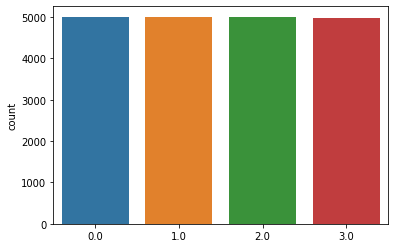

In [5]:
sns.countplot(df['x'][:,-2]), cat_idx

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

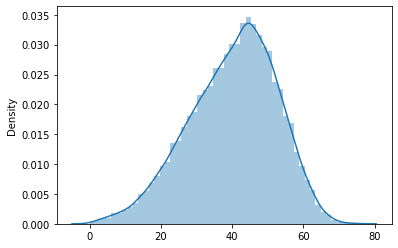

In [6]:
sns.distplot(df['T'])

In [7]:
from data.utils import *
nsamples, ncov= df['x'].shape
np.random.seed(123)
all_idx = np.arange(nsamples)
all_idx = np.random.permutation(all_idx)
train_idx = all_idx[:int(2*nsamples/3)]
valid_idx = all_idx[int(2*nsamples/3):]

train = formatted_data(df['x'], df['t'], df['e'], train_idx)
valid = formatted_data(df['x'], df['t'], df['e'], valid_idx)

del df

observed fold:1.0
observed fold:1.0


### Embedding the covariates into $\mathbb{R}^m$
- for each continuous variable, first find $m$ landmarkers, then interpolate values in between
- for each categorical variable, find the matched embedding vector with $m$ dimensions

Define landmarkers for each continuous variable### Embedding the covariates into $\mathbb{R}^m$

In [8]:
def landmarks_init(dataset, m, cts_var=None, cts_idx = None, device='cpu'):
    '''
    continuous_idx: 
    
    '''
    if type(cts_var) == type(None):
        cts_idx = np.arange(dataset['x'].shape[1])
        cts_var = cts_idx
    
    # creat landmarks as traditional dictionary
    x_landmarks = {}

    [x_landmarks.update({var: torch.tensor(np.percentile(dataset['x'][:,c_idx], np.linspace(0,100,m))).to(device).contiguous()}) for c_idx, var in zip(cts_idx, cts_var)]

    # save the initialized landmarks as a torch parameter dictionary
    x_emb_landmarks = nn.ParameterDict({})
    for var in cts_var:
        m = len(x_landmarks[var])
        x_emb_landmark = torch.eye(m)
        new_dict = nn.ParameterDict({var:torch.nn.Parameter(x_emb_landmark)})
        x_emb_landmarks.update(new_dict)
        
    return x_landmarks, x_emb_landmarks

# x_landmarks, x_emb_landmarks = landmarks_init(train, m, continuous_variables)
# x_landmarks, x_emb_landmarks

In [9]:
# x_landmarks, x_emb_landmarks = landmarks_init(train, 10, cts_var, cts_idx, device='cuda')
# x_landmarks, x_emb_landmarks

In [10]:
# x_landmarks.keys(), x_emb_landmarks.keys()

### Linear Interpolation for continuous variables

$x_b \le x < x_{b+1}$, $\text{emb}(x) = \text{emb}(x_b) + \frac{\text{emb}(x_{b+1}) - \text{emb}(x_b)}{x_{b+1}-x_b}(x-x_{b})$

In [11]:

# def linear_interpolation_np(x, x_landmarks):
#     # apply numpy package
#     m = len(x_landmarks)
#     x_emb_landmarks = np.eye(m)
#     # returns index
#     # a[i-1] < v <= a[i]
#     indx = np.searchsorted(x_landmarks, x)
#     # combine the first two indices, and the last two indices
#     # to include the unobserved minimum and maximum value
#     # combines [0,1], and [m-1, m]
#     indx = np.where(indx==0, 1, indx)
#     indx = np.where(indx==m, m-1, indx)

#     # linear interpolation
#     def helper(idx, x0):
#         return x_emb_landmarks[idx-1] + (x0-x_landmarks[idx-1])*(x_emb_landmarks[idx] - x_emb_landmarks[idx-1])/(x_landmarks[idx]-x_landmarks[idx-1])
    
#     out = [helper(idx,x0) for idx, x0 in zip(indx, x)]
#     print(np.vstack(out))


def linear_interpolation_var(x, x_landmark, x_emb_landmark):
    # written for torch
    # returns index
    # a[i-1] < v <= a[i]
    indx = torch.searchsorted(x_landmark, x)
    # combine the first two indices, and the last two indices
    # to include the unobserved minimum and maximum value
    # combines [0,1], and [m-1, m]
    indx = torch.where(indx==0, 1, indx)
    indx = torch.where(indx==m, m-1, indx)

    # linear interpolation
    def helper(idx, x0):
        return x_emb_landmark[idx-1] + (x0-x_landmark[idx-1])*(x_emb_landmark[idx] - x_emb_landmark[idx-1])/(x_landmark[idx]-x_landmark[idx-1])
    
    out = [helper(idx,x0) for idx, x0 in zip(indx, x)]
#     print(torch.vstack(out))
    return torch.vstack(out)

In [12]:
def cts_interpolation(x, x_landmarks, x_emb_landmarks, cts_var=None, cts_idx=None):
    
#     m = len(x_landmarks[0])
    if type(cts_var) == type(None):
        cts_var = x_landmarks.keys()
    # find values variable by variable
    res = []
    for c_idx, var in zip(cts_idx, cts_var):
        m = len(x_landmarks[var])
        cur_emb = linear_interpolation_var(x[:,c_idx], x_landmarks[var], x_emb_landmarks[var])
        # reshape to dimension [batch_size, 1, m]
        res.append(cur_emb.view(-1,1,m))
        
    return torch.cat(res, 1)
#     return torch.cat(res, 1)

In [13]:
# cts_interpolation(torch.tensor(train['x'][:20]).float(), x_landmarks, x_emb_landmarks, cts_var, cts_idx, device)

In [14]:
    '''
    To handle missingness, indicating by a masking matrix
    1 for observed, 0 for censored
    
    If missing, no need to interpolation at this location
    '''

# def cts_interpolation_mask(x, x_landmarks, x_emb_landmarks, continuous_variables=None, device='cpu'):
#     '''
#     To handle missingness, indicating by a masking matrix
#     1 for observed, 0 for censored
    
#     To be completed
#     '''
#     m = len(x_landmarks[0])
#     if type(continuous_variables) == type(None):
#         continuous_variables = np.arange(len(x_landmarks))
#     # find values variable by variable
#     res = []
#     for var in continuous_variables:
#         cur_emb = linear_interpolation_var(x[:,var], x_landmarks[var], x_emb_landmarks[var], device=device)
#         # reshape to dimension [batch_size, 1, m]
#         res.append(cur_emb.view(-1,1,m))
        
#     return torch.cat(res, 1)
# #     return torch.cat(res, 1)

'\nTo handle missingness, indicating by a masking matrix\n1 for observed, 0 for censored\n\nIf missing, no need to interpolation at this location\n'

In [15]:
# x_cts_emb = cts_interpolation(torch.tensor(train['x'][:10]), x_landmarks, x_emb_landmarks, continuous_variables)
# x_cts_emb

### Embedding categorical variables

Embed each level ($l$) of categorical variable, i.e., mapping each digit label to a length-m embedding vector, the $l$-th row of the embedding matrix.

In [16]:
# save variable name and levels as a dictionary
# x_levels = {}
# [x_levels.update({var:len(np.unique(df['x'][:,var]))}) for var in categorical_variables]

def level_init(dataset, m, cat_var=None, cat_idx=None):
#     if type(categorical_variables)==type(None):
#         categorical_variables = np.arange(len(x_levels))
    x_levels = {} 
    [x_levels.update({var:len(np.unique(dataset['x'][:,c_idx]))}) for c_idx, var in zip(cat_idx, cat_var)]
    # save the initialized landmarks as a dictionary
    x_emb_levels = nn.ParameterDict({})
    for var in cat_var:
        level = x_levels[var]
        # randomly pick one position as 1
        idx = np.random.choice(m)
        x_emb_level = torch.zeros(level, m)
#         x_emb_level = F.softmax(torch.rand(level, m),dim=-1)

        for l in range(level):
            idx = np.random.choice(m)
            x_emb_level[l, idx] = 1.0
    
        new_dict = nn.ParameterDict({var:torch.nn.Parameter(x_emb_level)})
        x_emb_levels.update(new_dict)
    return x_levels, x_emb_levels

In [17]:
# save variable name and levels as a dictionary
# x_levels = {}
# [x_levels.update({var:len(np.unique(df['x'][:,var]))}) for var in categorical_variables]

# def level_init(dataset, m, cat_var=None, cat_idx=None):
# #     if type(categorical_variables)==type(None):
# #         categorical_variables = np.arange(len(x_levels))
#     x_levels = {} 
#     [x_levels.update({var:len(np.unique(dataset['x'][:,c_idx]))}) for c_idx, var in zip(cat_idx, cat_var)]
#     # save the initialized landmarks as a dictionary
#     x_emb_levels = nn.ParameterDict({})
#     for var in cat_var:
#         level = x_levels[var]
#         # randomly pick one position as 1
#         idx = np.random.choice(m)
#         x_emb_level = torch.nn.Embedding(level, m)
    
#         new_dict = nn.ParameterDict({var:x_emb_level})
#         x_emb_levels.update(new_dict)
#     return x_levels, x_emb_levels

In [18]:
# x_levels, x_emb_levels = level_init(train, 10, cat_var, cat_idx)
# x_levels, x_emb_levels

In [19]:
def cat_interpolation(x, x_emb_levels, cat_var=None, cat_idx = None):
    if type(cat_var) == type(None):
        cat_var = x_emb_levels.keys()
    # find values variable by variable
    res = []
    for c_idx, var in zip(cat_idx, cat_var):
        cur_emb = x_emb_levels[var][x[:,c_idx].long()]
        # reshape to dimension [batch_size, 1, m]
        res.append(cur_emb.view(-1,1,m))
        
    return torch.cat(res, 1)
    

Linear interpolation batch by batch

In [20]:
# m = 10
# device='cpu'
# # Initiate landmarks with trainable paramters
# x_landmarks, x_emb_landmarks = landmarks_init(train, m, cts_var, cts_idx, device)
# x_levels, x_emb_levels = level_init(train, m, cat_var, cat_idx, device)

# 
# 
def cov_embedding(x, m, cts_var=None, cts_idx = None, x_landmarks=None, x_emb_landmarks=None,
                  cat_var=[], cat_idx = [], x_levels=None, x_emb_levels=None):
    '''
    Do the transformation within each minibatch

    m: length of the embedding vector for each covariates

    cts_var: list of the names of continuous variables
    cat_var: list of the names of categorical variables

    x_landmarks: dictionary with continuous names as keys, and the percentile landmarks as items
    x_emb_landmarks: dictionary with continuous names as keys, and the embedding landmarks as items

    x_levels: dictionary with categorical names as keys, and the number of levels per covariate as items
    x_emb_levels: dictionary with categorical names as keys, and the embedding vectors as items
    '''
    x_emb = []
    var_list = []
    if type(cts_var) != type(None):
        x_emb.append(cts_interpolation(x, x_landmarks, x_emb_landmarks, cts_var, cts_idx))
        var_list.extend(list(x_emb_landmarks.keys()))
        
    if len(cat_var) >0:
        x_emb.append(cat_interpolation(x, x_emb_levels, cat_var, cat_idx))
        var_list.extend(list(x_emb_levels.keys()))
    
    x_emb = torch.cat(x_emb, 1)
#     cur_var_list = torch.cat(var_list)
#     print(var_list)
    return x_emb, var_list
        

In [21]:
# batch_emb, var_list = cov_embedding(torch.tensor(train['x'][:20]).float(), 10, cts_var, cts_idx, x_landmarks, x_emb_landmarks,
#                                     cat_var, cat_idx, x_levels, x_emb_levels)
# batch_emb.shape

In [22]:
len(cat_idx)

2

In [23]:
class Embedding(nn.Module):
    '''
    create embedding paramters
    '''
    def __init__(self, dataset, cts_var, cts_idx, cat_var=[], cat_idx=[], dropout=0.0, m=10, device='cuda'):
        super(Embedding, self).__init__()
        self.m = m
        self.cts_var, self.cts_idx, self.cat_var, self.cat_idx =  cts_var, cts_idx, cat_var, cat_idx
        # Initiate landmarks with trainable paramters
        self.x_landmarks, self.x_emb_landmarks = landmarks_init(dataset, m, cts_var, cts_idx, device)
        if len(cat_idx) > 0:
            self.x_levels, self.x_emb_levels = level_init(dataset, m, cat_var, cat_idx)
        else:
            self.x_levels, self.x_emb_levels = None, None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x, mask=None):
        x_emb, var_list = cov_embedding(x.float(), self.m,\
                                        self.cts_var, self.cts_idx, self.x_landmarks, self.x_emb_landmarks,\
                                        self.cat_var, self.cat_idx, self.x_levels, self.x_emb_levels)
        return self.dropout(x_emb)



In [24]:
class Linear(nn.Module):
    '''
    create linear combinations for different embedded vectors
    '''
    def __init__(self, dropout):
        super(Linear, self).__init__()
#         self.weights = torch.nn.Parameter(F.softmax(torch.rand(ncov), dim=-1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x_emb):
        # with shape [batch_size, ncov, m]
#         x_emb = x_emb.permute(0,2,1)
        # now it has shape [batch_size, m, ncov]
        # comparing to an image, m is like the channel
        return self.flatten(self.dropout(x_emb))
    
class LinearAtt(nn.Module):
    '''
    create linear combinations for different embedded vectors
    '''
    def __init__(self, ncov, dropout):
        super(LinearAtt, self).__init__()
#         self.weights = torch.nn.Parameter(F.softmax(torch.rand(ncov), dim=-1))
#         self.flatten = nn.Flatten()
#         self.dropout = nn.Dropout(p=dropout)
        self.weights = torch.nn.Parameter(F.softmax(torch.rand(ncov), dim=-1))

    def forward(self, x_emb):
        # with shape [batch_size, ncov, m]
        x_emb = x_emb.permute(0,2,1)
        # now it has shape [batch_size, m, ncov]
        # comparing to an image, m is like the channel
        return (x_emb * self.weights).sum(-1)
        

In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import math
import numpy as np

class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """
    def __init__(self, dropout=0.1):
        super(Attention, self).__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, query, key, value, mask=None):

        # scores = torch.matmul(query, key.transpose(-2, -1)) \
        #          / math.sqrt(query.size(-1))
        
        # f(query, key)
        # query: d \times m
        # (d x m ) x (m x d)
        # d \times d
        scores = torch.exp(torch.matmul(query, key.transpose(-2, -1))) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

#         if dropout is not None:
        p_attn = self.dropout(p_attn)
        output = torch.matmul(p_attn, value)
        
        return self.flatten(output), p_attn
            

In [26]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

    
class DecMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(DecMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
#         self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        # reshape to original shape?
        return z
    
# class Embedding(nn.Module):
#     def __init__(self, ncov, z_dim, h_dim=[32,32]):
#         super(Embedding, self).__init__()
#         self.enc = EncEmbedding(input_size=ncov, output_size=z_dim, h_dim=h_dim)
#         self.dec = DecEmbdedding(input_size=z_dim, output_size=ncov, h_dim=h_dim)
#     def forward(self, x, mask=True):
#         z = self.enc(x)
#         rec_x = self.dec(z)
        
#         return z, rec_x

In [27]:
# # with transformation
# ncov = train['x'].shape[1]
# covList = np.arange(ncov)
# mean = np.mean(train['x'], axis=0)
# std = np.std(train['x'], axis=0)

# trainData = SimpleDataset_trans(train['x'], train['t'], train['e'], transform=True, mean=mean, std = std)
# pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
# pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

# validData = SimpleDataset_trans(valid['x'], valid['t'], valid['e'], transform=True, mean=mean, std = std)
# v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# # v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

In [28]:
ncov = train['x'].shape[1]
covList = np.arange(ncov)

trainData = SimpleDataset(train['x'], train['t'], train['e'])
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(valid['x'], valid['t'], valid['e'])
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)


In [29]:


result_path_root

'/data/zidi/ACSurv/results/toy'

In [30]:
m=10
zdim = m
epochs = 1000
device = 'cuda'
model_name = 'LinearAtt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)


result_path = result_path_root+'/saved_models/'
Path(result_path).mkdir(parents=True, exist_ok=True)

'''covariate embedding'''
embedding = Embedding(train, cts_var, cts_idx, cat_var, cat_idx, m=m)

'''attention network'''
attention = LinearAtt(ncov=ncov, dropout=0.1)
# attention = Attention(dropout=0.1)

'''decoding the embedded vectors'''
decoder = DecMLP(input_size = zdim, output_size = 1, h_dim=[512, 512])

embedding.to(device)
attention.to(device)
decoder.to(device)

# define optimizer
opt_emb = optim.Adam(embedding.parameters(), lr=1e-3)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)
opt_att = optim.Adam(attention.parameters(), lr=1e-4)

emb_path = result_path+model_name+'_emb.pt'
dec_path = result_path+model_name+'_dec.pt'
att_path = result_path+model_name+'_att.pt'
print(embedding, attention, decoder)

Embedding(
  (x_emb_landmarks): ParameterDict(
      (AGE): Parameter containing: [torch.cuda.FloatTensor of size 10x10 (GPU 0)]
      (RANDON): Parameter containing: [torch.cuda.FloatTensor of size 10x10 (GPU 0)]
  )
  (x_emb_levels): ParameterDict(
      (cat0): Parameter containing: [torch.cuda.FloatTensor of size 4x10 (GPU 0)]
      (cat1): Parameter containing: [torch.cuda.FloatTensor of size 100x10 (GPU 0)]
  )
  (dropout): Dropout(p=0.0, inplace=False)
) LinearAtt() DecMLP(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


Text(0.5, 1.0, 'AGE embedding')

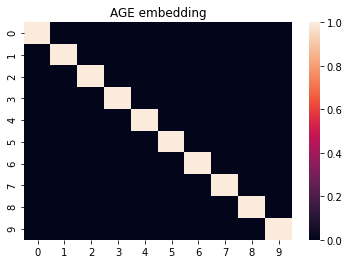

In [31]:
ax = sns.heatmap(embedding.x_emb_landmarks['AGE'].detach().cpu().numpy())
plt.title('AGE embedding')

Text(0.5, 1.0, 'RANDON embedding')

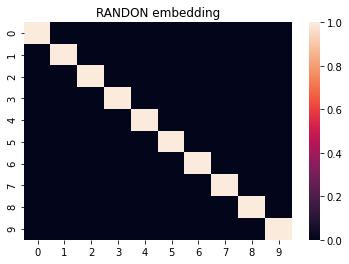

In [32]:
ax = sns.heatmap(embedding.x_emb_landmarks['RANDON'].detach().cpu().numpy())
plt.title('RANDON embedding')

Text(0.5, 1.0, 'CAT0 embedding')

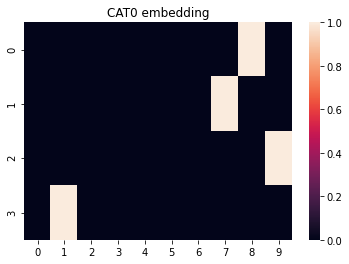

In [33]:
ax = sns.heatmap(embedding.x_emb_levels['cat0'].detach().cpu().numpy())
plt.title('CAT0 embedding')

Text(0.5, 1.0, 'CAT1 embedding')

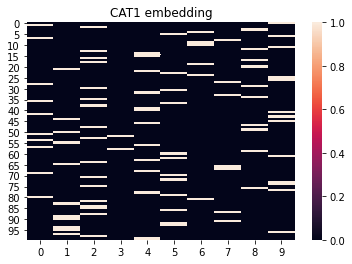

In [34]:
ax = sns.heatmap(embedding.x_emb_levels['cat1'].detach().cpu().numpy())
plt.title('CAT1 embedding')

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Linear Attention Weights')

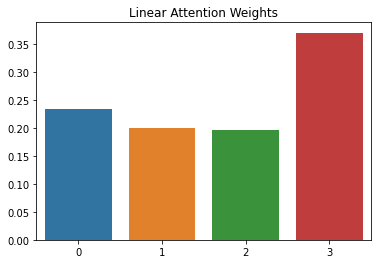

In [35]:
sns.barplot(np.arange(ncov),attention.weights.detach().cpu().numpy())
plt.title('Linear Attention Weights')

epoch1


<ipython-input-11-8b2dc3ae2521>:26: UserWarning: input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378062065/work/aten/src/ATen/native/BucketizationUtils.h:20.)
  indx = torch.searchsorted(x_landmark, x)


====> Train NLL: 22941100.9698 	 Valid event loss: 11408117.9955 	 censoring loss : 0.0000 	 Improved: *
epoch2
====> Train NLL: 22004520.3963 	 Valid event loss: 10889851.9014 	 censoring loss : 0.0000 	 Improved: *
epoch3
====> Train NLL: 20893714.3057 	 Valid event loss: 10275755.2439 	 censoring loss : 0.0000 	 Improved: *
epoch4
====> Train NLL: 19552584.4642 	 Valid event loss: 9519242.7361 	 censoring loss : 0.0000 	 Improved: *
epoch5
====> Train NLL: 17880934.0102 	 Valid event loss: 8574748.6815 	 censoring loss : 0.0000 	 Improved: *
epoch6
====> Train NLL: 15797391.1929 	 Valid event loss: 7389251.2828 	 censoring loss : 0.0000 	 Improved: *
epoch7
====> Train NLL: 13209216.7952 	 Valid event loss: 5954828.0556 	 censoring loss : 0.0000 	 Improved: *
epoch8
====> Train NLL: 10184692.6239 	 Valid event loss: 4341659.9340 	 censoring loss : 0.0000 	 Improved: *
epoch9
====> Train NLL: 6955931.0349 	 Valid event loss: 2715563.3615 	 censoring loss : 0.0000 	 Improved: *
epoch1

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


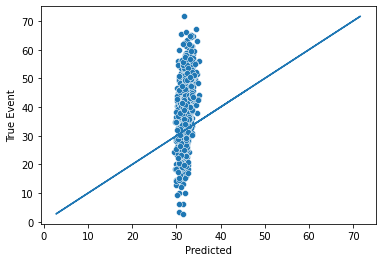

====> Train NLL: 3994140.8515 	 Valid event loss: 1394330.0600 	 censoring loss : 0.0000 	 Improved: *
epoch11
====> Train NLL: 2049108.3545 	 Valid event loss: 822695.7534 	 censoring loss : 0.0000 	 Improved: *
epoch12
====> Train NLL: 1538508.7804 	 Valid event loss: 691640.3413 	 censoring loss : 0.0000 	 Improved: *
epoch13
====> Train NLL: 1265998.0509 	 Valid event loss: 558143.2396 	 censoring loss : 0.0000 	 Improved: *
epoch14
====> Train NLL: 1018120.6917 	 Valid event loss: 449479.5878 	 censoring loss : 0.0000 	 Improved: *
epoch15
====> Train NLL: 813163.6378 	 Valid event loss: 356746.0209 	 censoring loss : 0.0000 	 Improved: *
epoch16
====> Train NLL: 658129.1303 	 Valid event loss: 292902.8967 	 censoring loss : 0.0000 	 Improved: *
epoch17
====> Train NLL: 559602.9210 	 Valid event loss: 259986.8701 	 censoring loss : 0.0000 	 Improved: *
epoch18
====> Train NLL: 516501.6089 	 Valid event loss: 248771.6370 	 censoring loss : 0.0000 	 Improved: *
epoch19
====> Train N

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


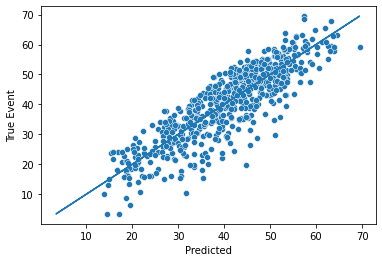

====> Train NLL: 499138.7764 	 Valid event loss: 244174.3296 	 censoring loss : 0.0000 	 Improved: *
epoch21
====> Train NLL: 496135.0734 	 Valid event loss: 242792.1629 	 censoring loss : 0.0000 	 Improved: *
epoch22
====> Train NLL: 493548.2361 	 Valid event loss: 242117.7034 	 censoring loss : 0.0000 	 Improved: *
epoch23
====> Train NLL: 491497.4199 	 Valid event loss: 240969.1924 	 censoring loss : 0.0000 	 Improved: *
epoch24
====> Train NLL: 490523.1420 	 Valid event loss: 241674.7371 	 censoring loss : 0.0000 	 Improved:  
epoch25
====> Train NLL: 488507.3796 	 Valid event loss: 240230.3111 	 censoring loss : 0.0000 	 Improved: *
epoch26
====> Train NLL: 487604.0701 	 Valid event loss: 239606.9423 	 censoring loss : 0.0000 	 Improved: *
epoch27
====> Train NLL: 486890.4199 	 Valid event loss: 239660.8549 	 censoring loss : 0.0000 	 Improved:  
epoch28
====> Train NLL: 486187.4087 	 Valid event loss: 239213.2610 	 censoring loss : 0.0000 	 Improved: *
epoch29
====> Train NLL: 48

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


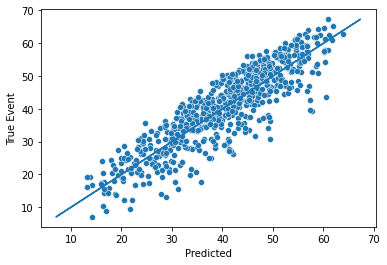

====> Train NLL: 485262.9365 	 Valid event loss: 238951.8885 	 censoring loss : 0.0000 	 Improved: *
epoch31
====> Train NLL: 485096.5333 	 Valid event loss: 239959.2923 	 censoring loss : 0.0000 	 Improved:  
epoch32
====> Train NLL: 484964.9283 	 Valid event loss: 239012.2126 	 censoring loss : 0.0000 	 Improved:  
epoch33
====> Train NLL: 484744.5711 	 Valid event loss: 238468.7033 	 censoring loss : 0.0000 	 Improved: *
epoch34
====> Train NLL: 485056.6914 	 Valid event loss: 238583.6410 	 censoring loss : 0.0000 	 Improved:  
epoch35
====> Train NLL: 485076.0944 	 Valid event loss: 238378.6443 	 censoring loss : 0.0000 	 Improved: *
epoch36
====> Train NLL: 483998.3039 	 Valid event loss: 238668.5552 	 censoring loss : 0.0000 	 Improved:  
epoch37
====> Train NLL: 484183.8891 	 Valid event loss: 239392.4743 	 censoring loss : 0.0000 	 Improved:  
epoch38
====> Train NLL: 484272.1833 	 Valid event loss: 239067.2735 	 censoring loss : 0.0000 	 Improved:  
epoch39
====> Train NLL: 48

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


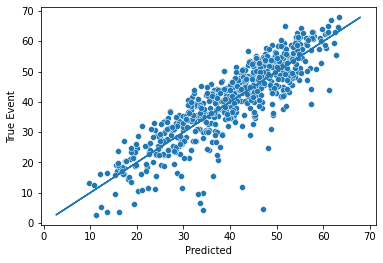

====> Train NLL: 483660.1294 	 Valid event loss: 239565.6804 	 censoring loss : 0.0000 	 Improved:  
epoch41
====> Train NLL: 484004.1626 	 Valid event loss: 238688.3372 	 censoring loss : 0.0000 	 Improved:  
epoch42
====> Train NLL: 485117.1821 	 Valid event loss: 239151.7388 	 censoring loss : 0.0000 	 Improved:  
epoch43
====> Train NLL: 483590.7310 	 Valid event loss: 238982.9334 	 censoring loss : 0.0000 	 Improved:  
epoch44
====> Train NLL: 482885.4178 	 Valid event loss: 238495.5271 	 censoring loss : 0.0000 	 Improved:  
epoch45
====> Train NLL: 482917.8512 	 Valid event loss: 238964.0268 	 censoring loss : 0.0000 	 Improved:  
epoch46
====> Train NLL: 483207.7894 	 Valid event loss: 239194.3423 	 censoring loss : 0.0000 	 Improved:  
epoch47
====> Train NLL: 482900.2779 	 Valid event loss: 238689.3362 	 censoring loss : 0.0000 	 Improved:  
epoch48
====> Train NLL: 483064.4948 	 Valid event loss: 239917.9377 	 censoring loss : 0.0000 	 Improved:  
epoch49
====> Train NLL: 48

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


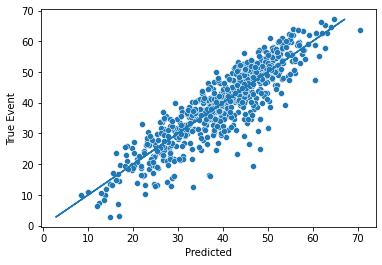

====> Train NLL: 482686.8815 	 Valid event loss: 238597.1307 	 censoring loss : 0.0000 	 Improved:  
epoch51
====> Train NLL: 482982.4119 	 Valid event loss: 238672.2001 	 censoring loss : 0.0000 	 Improved:  
epoch52
====> Train NLL: 482648.1979 	 Valid event loss: 238366.3449 	 censoring loss : 0.0000 	 Improved: *
epoch53
====> Train NLL: 482630.3141 	 Valid event loss: 238393.8246 	 censoring loss : 0.0000 	 Improved:  
epoch54
====> Train NLL: 482852.5034 	 Valid event loss: 239224.6275 	 censoring loss : 0.0000 	 Improved:  
epoch55
====> Train NLL: 482071.0209 	 Valid event loss: 240572.7819 	 censoring loss : 0.0000 	 Improved:  
epoch56
====> Train NLL: 482723.3663 	 Valid event loss: 239292.9096 	 censoring loss : 0.0000 	 Improved:  
epoch57
====> Train NLL: 482349.1622 	 Valid event loss: 238342.4734 	 censoring loss : 0.0000 	 Improved: *
epoch58
====> Train NLL: 483059.1224 	 Valid event loss: 238410.9677 	 censoring loss : 0.0000 	 Improved:  
epoch59
====> Train NLL: 48

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


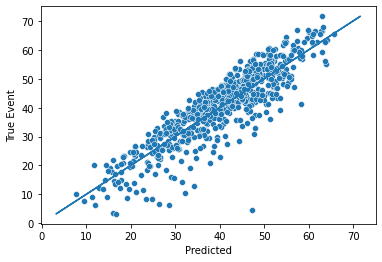

====> Train NLL: 482638.6996 	 Valid event loss: 238759.0508 	 censoring loss : 0.0000 	 Improved:  
epoch61
====> Train NLL: 484072.5375 	 Valid event loss: 238346.1442 	 censoring loss : 0.0000 	 Improved:  
epoch62
====> Train NLL: 483786.3081 	 Valid event loss: 238542.7220 	 censoring loss : 0.0000 	 Improved:  
epoch63
====> Train NLL: 481808.7609 	 Valid event loss: 238869.5787 	 censoring loss : 0.0000 	 Improved:  
epoch64
====> Train NLL: 482061.4212 	 Valid event loss: 239495.8232 	 censoring loss : 0.0000 	 Improved:  
epoch65
====> Train NLL: 482632.2646 	 Valid event loss: 239023.2397 	 censoring loss : 0.0000 	 Improved:  
epoch66
====> Train NLL: 481968.5507 	 Valid event loss: 240343.8113 	 censoring loss : 0.0000 	 Improved:  
epoch67
====> Train NLL: 481534.7499 	 Valid event loss: 239465.0778 	 censoring loss : 0.0000 	 Improved:  
epoch68
====> Train NLL: 481873.6282 	 Valid event loss: 238143.8726 	 censoring loss : 0.0000 	 Improved: *
epoch69
====> Train NLL: 48

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


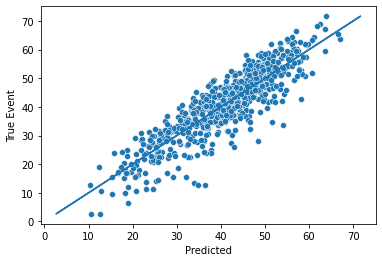

====> Train NLL: 482311.5361 	 Valid event loss: 238609.9718 	 censoring loss : 0.0000 	 Improved:  
epoch71
====> Train NLL: 481468.0822 	 Valid event loss: 238465.5950 	 censoring loss : 0.0000 	 Improved:  
epoch72
====> Train NLL: 481752.6277 	 Valid event loss: 238493.0361 	 censoring loss : 0.0000 	 Improved:  
epoch73
====> Train NLL: 481170.2976 	 Valid event loss: 238206.3644 	 censoring loss : 0.0000 	 Improved:  
epoch74
====> Train NLL: 481731.6129 	 Valid event loss: 238926.2815 	 censoring loss : 0.0000 	 Improved:  
epoch75
====> Train NLL: 481371.4627 	 Valid event loss: 238067.9213 	 censoring loss : 0.0000 	 Improved: *
epoch76
====> Train NLL: 481434.3705 	 Valid event loss: 238129.3848 	 censoring loss : 0.0000 	 Improved:  
epoch77
====> Train NLL: 481571.2347 	 Valid event loss: 238783.4950 	 censoring loss : 0.0000 	 Improved:  
epoch78
====> Train NLL: 481290.1026 	 Valid event loss: 238194.2382 	 censoring loss : 0.0000 	 Improved:  
epoch79
====> Train NLL: 48

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


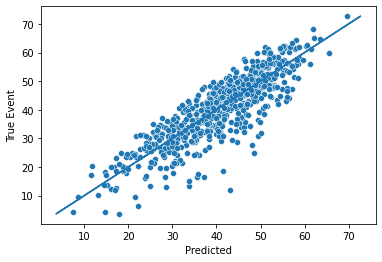

====> Train NLL: 480966.5381 	 Valid event loss: 238118.3657 	 censoring loss : 0.0000 	 Improved:  
epoch81
====> Train NLL: 481121.9035 	 Valid event loss: 238223.2461 	 censoring loss : 0.0000 	 Improved:  
epoch82
====> Train NLL: 481051.4834 	 Valid event loss: 238025.5000 	 censoring loss : 0.0000 	 Improved: *
epoch83
====> Train NLL: 480849.1197 	 Valid event loss: 239347.0736 	 censoring loss : 0.0000 	 Improved:  
epoch84
====> Train NLL: 480697.7057 	 Valid event loss: 241599.0502 	 censoring loss : 0.0000 	 Improved:  
epoch85
====> Train NLL: 481596.6351 	 Valid event loss: 238552.3807 	 censoring loss : 0.0000 	 Improved:  
epoch86
====> Train NLL: 480688.1086 	 Valid event loss: 238045.0971 	 censoring loss : 0.0000 	 Improved:  
epoch87
====> Train NLL: 481110.7149 	 Valid event loss: 239886.5900 	 censoring loss : 0.0000 	 Improved:  
epoch88
====> Train NLL: 480808.8102 	 Valid event loss: 237948.0557 	 censoring loss : 0.0000 	 Improved: *
epoch89
====> Train NLL: 48

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


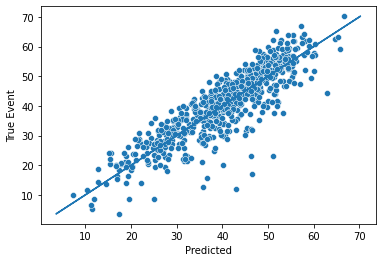

====> Train NLL: 480521.4916 	 Valid event loss: 238156.3826 	 censoring loss : 0.0000 	 Improved:  
epoch91
====> Train NLL: 480787.3249 	 Valid event loss: 238921.3662 	 censoring loss : 0.0000 	 Improved:  
epoch92
====> Train NLL: 481042.1029 	 Valid event loss: 238143.2830 	 censoring loss : 0.0000 	 Improved:  
epoch93
====> Train NLL: 480669.8480 	 Valid event loss: 238889.4578 	 censoring loss : 0.0000 	 Improved:  
epoch94
====> Train NLL: 480863.2092 	 Valid event loss: 238085.0315 	 censoring loss : 0.0000 	 Improved:  
epoch95
====> Train NLL: 480944.8548 	 Valid event loss: 238152.0788 	 censoring loss : 0.0000 	 Improved:  
epoch96
====> Train NLL: 480362.6288 	 Valid event loss: 237928.6244 	 censoring loss : 0.0000 	 Improved: *
epoch97
====> Train NLL: 480607.6722 	 Valid event loss: 237870.0158 	 censoring loss : 0.0000 	 Improved: *
epoch98
====> Train NLL: 480409.9109 	 Valid event loss: 238064.7268 	 censoring loss : 0.0000 	 Improved:  
epoch99
====> Train NLL: 48

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


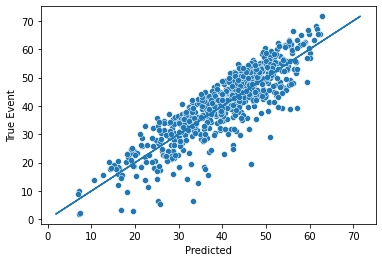

====> Train NLL: 480562.3837 	 Valid event loss: 238186.9144 	 censoring loss : 0.0000 	 Improved:  
epoch101
====> Train NLL: 480771.2593 	 Valid event loss: 237840.3327 	 censoring loss : 0.0000 	 Improved: *
epoch102
====> Train NLL: 480253.4290 	 Valid event loss: 238360.7257 	 censoring loss : 0.0000 	 Improved:  
epoch103
====> Train NLL: 480097.6687 	 Valid event loss: 237762.1854 	 censoring loss : 0.0000 	 Improved: *
epoch104
====> Train NLL: 479828.7261 	 Valid event loss: 238186.2592 	 censoring loss : 0.0000 	 Improved:  
epoch105
====> Train NLL: 479778.8039 	 Valid event loss: 238101.3122 	 censoring loss : 0.0000 	 Improved:  
epoch106
====> Train NLL: 481251.2956 	 Valid event loss: 237840.7612 	 censoring loss : 0.0000 	 Improved:  
epoch107
====> Train NLL: 479913.0421 	 Valid event loss: 237939.7040 	 censoring loss : 0.0000 	 Improved:  
epoch108
====> Train NLL: 479860.0275 	 Valid event loss: 239112.6169 	 censoring loss : 0.0000 	 Improved:  
epoch109
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


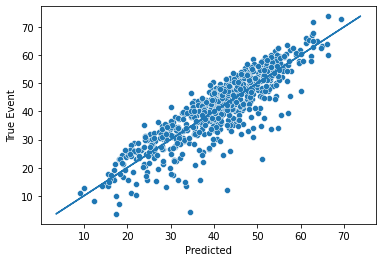

====> Train NLL: 479719.5259 	 Valid event loss: 238167.3847 	 censoring loss : 0.0000 	 Improved:  
epoch111
====> Train NLL: 479468.7918 	 Valid event loss: 237951.4081 	 censoring loss : 0.0000 	 Improved:  
epoch112
====> Train NLL: 479615.6282 	 Valid event loss: 238101.3240 	 censoring loss : 0.0000 	 Improved:  
epoch113
====> Train NLL: 479384.2148 	 Valid event loss: 237857.7712 	 censoring loss : 0.0000 	 Improved:  
epoch114
====> Train NLL: 479673.4416 	 Valid event loss: 239199.9959 	 censoring loss : 0.0000 	 Improved:  
epoch115
====> Train NLL: 479995.0889 	 Valid event loss: 239026.2448 	 censoring loss : 0.0000 	 Improved:  
epoch116
====> Train NLL: 480820.1676 	 Valid event loss: 239969.2253 	 censoring loss : 0.0000 	 Improved:  
epoch117
====> Train NLL: 480083.1302 	 Valid event loss: 238199.2645 	 censoring loss : 0.0000 	 Improved:  
epoch118
====> Train NLL: 479431.4913 	 Valid event loss: 237948.5917 	 censoring loss : 0.0000 	 Improved:  
epoch119
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


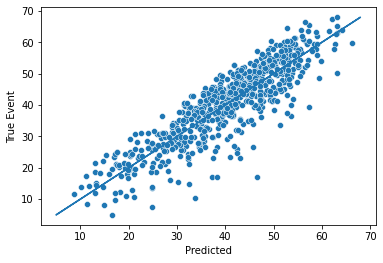

====> Train NLL: 479179.6709 	 Valid event loss: 238205.9991 	 censoring loss : 0.0000 	 Improved:  
epoch121
====> Train NLL: 478878.6969 	 Valid event loss: 238439.3883 	 censoring loss : 0.0000 	 Improved:  
epoch122
====> Train NLL: 480385.7754 	 Valid event loss: 238372.9279 	 censoring loss : 0.0000 	 Improved:  
epoch123
====> Train NLL: 479619.3331 	 Valid event loss: 237907.9829 	 censoring loss : 0.0000 	 Improved:  
epoch124
====> Train NLL: 480354.0467 	 Valid event loss: 241932.8122 	 censoring loss : 0.0000 	 Improved:  
epoch125
====> Train NLL: 479787.1841 	 Valid event loss: 238363.4771 	 censoring loss : 0.0000 	 Improved:  
epoch126
====> Train NLL: 479138.7081 	 Valid event loss: 238085.2979 	 censoring loss : 0.0000 	 Improved:  
epoch127
====> Train NLL: 478895.5664 	 Valid event loss: 238834.8008 	 censoring loss : 0.0000 	 Improved:  
epoch128
====> Train NLL: 478942.4138 	 Valid event loss: 238410.6818 	 censoring loss : 0.0000 	 Improved:  
epoch129
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


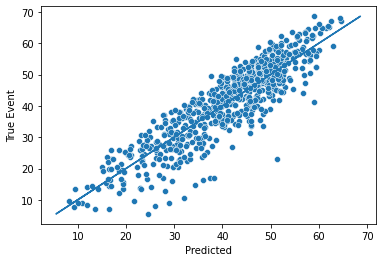

====> Train NLL: 479393.5749 	 Valid event loss: 237822.6997 	 censoring loss : 0.0000 	 Improved:  
epoch131
====> Train NLL: 479941.1933 	 Valid event loss: 238088.1928 	 censoring loss : 0.0000 	 Improved:  
epoch132
====> Train NLL: 479077.2589 	 Valid event loss: 238288.6843 	 censoring loss : 0.0000 	 Improved:  
epoch133
====> Train NLL: 479356.7911 	 Valid event loss: 237865.5371 	 censoring loss : 0.0000 	 Improved:  
epoch134
====> Train NLL: 478916.4214 	 Valid event loss: 238456.2617 	 censoring loss : 0.0000 	 Improved:  
epoch135
====> Train NLL: 479167.0791 	 Valid event loss: 239519.2070 	 censoring loss : 0.0000 	 Improved:  
epoch136
====> Train NLL: 479175.6453 	 Valid event loss: 238037.4579 	 censoring loss : 0.0000 	 Improved:  
epoch137
====> Train NLL: 478448.9389 	 Valid event loss: 238052.4598 	 censoring loss : 0.0000 	 Improved:  
epoch138
====> Train NLL: 478915.7221 	 Valid event loss: 237852.7364 	 censoring loss : 0.0000 	 Improved:  
epoch139
====> Trai

In [36]:
best_valid_loss = np.inf
best_epoch = 0

train_loss_hist = []
valid_loss_hist = []
for epoch in range(1, epochs + 1):


    train_loss = 0
    valid_e_loss = 0
    valid_c_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "
    embedding.train()
    attention.train()
    decoder.train()
    for i, (x, y, e) in enumerate(pair1):
        
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb = embedding(x.float())
        z = attention(x_emb)

        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat-y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
        loss = closs + eloss
    
        
#         y_loglikeli = -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-4).log().mean()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(embedding.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(attention.parameters(), 1e-1)
        
        train_loss += loss.item()
        
        opt_emb.step()
        opt_att.step()
        opt_dec.step()  
        
#     train_loss = train_loss/(i+1)     

    
    embedding.eval()
    attention.eval()
    decoder.eval()
    
    valid_e_loss = 0
    valid_c_loss = 0
    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb = embedding(x.float())
        z = attention(x_emb)
#         z, attn_score = attention(x_emb,x_emb,x_emb)

        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
#         valid_loss_ = eloss.item()

        valid_e_loss += eloss.item()
        valid_c_loss += closs.item()



#     valid_e_loss = valid_e_loss/(i+1)
#     valid_c_loss = valid_c_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_e_loss)
    
    save_model = 0
    if (best_valid_loss > valid_e_loss):
        save_model += 1
        
    if epoch % 10 == 0:
        subj = np.random.choice(len(e))
        plt.figure()
        
        sns.scatterplot(t_hat[e==1].cpu().detach().numpy().squeeze(), y[e==1].cpu().detach().numpy().squeeze())
        plt.plot(y[e==1].cpu().detach().numpy().squeeze(), y[e==1].cpu().detach().numpy().squeeze())
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
        
        
#         plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

# #         sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
#         true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
#         sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
#         plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.
#         plt.title(r'$\delta$='+str(e[subj].item()))

        plt.show()
    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_e_loss
        torch.save(embedding.state_dict(), emb_path)
        torch.save(attention.state_dict(), att_path)
        torch.save(decoder.state_dict(), dec_path)

        improved_str = "*"
    print('====> Train NLL: {:.4f} \t Valid event loss: {:.4f} \t censoring loss : {:.4f} \t Improved: {}'.format(train_loss, valid_e_loss,valid_c_loss,improved_str))

    if epoch - best_epoch >=20:
        print('Model stopped due to early stopping')
        break

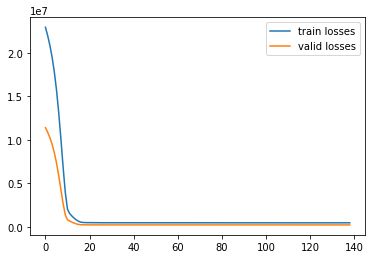

In [37]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()


In [38]:
embedding.load_state_dict(torch.load(emb_path))
attention.load_state_dict(torch.load(att_path))

decoder.load_state_dict(torch.load(dec_path))

# for name, param in embedding.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

<All keys matched successfully>

In [39]:
# sns.barplot(np.arange(ncov),attention.weights.detach().cpu().numpy())
# plt.title('Linear Attention Weights')

Text(0.5, 1.0, 'AGE embedding')

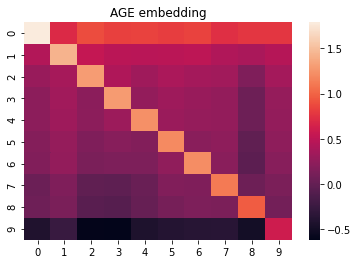

In [40]:
ax = sns.heatmap(embedding.x_emb_landmarks['AGE'].detach().cpu().numpy())
plt.title('AGE embedding')

Text(0.5, 1.0, 'RANDON embedding')

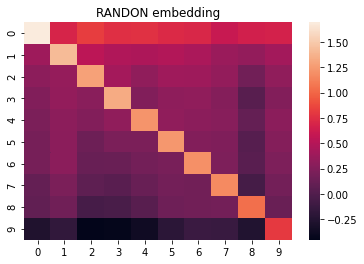

In [41]:
ax = sns.heatmap(embedding.x_emb_landmarks['RANDON'].detach().cpu().numpy())
plt.title('RANDON embedding')

Text(0.5, 1.0, 'CAT0 embedding')

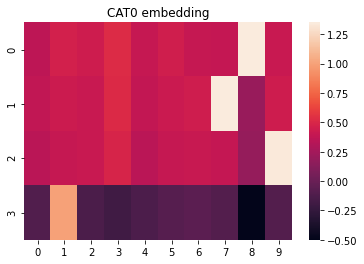

In [42]:
ax = sns.heatmap(embedding.x_emb_levels['cat0'].detach().cpu().numpy())
plt.title('CAT0 embedding')

Text(0.5, 1.0, 'CAT1 embedding')

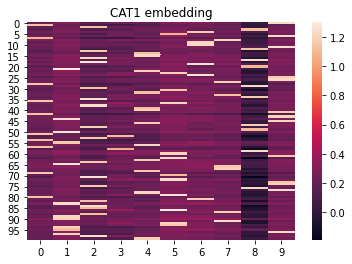

In [43]:
ax = sns.heatmap(embedding.x_emb_levels['cat1'].detach().cpu().numpy())
plt.title('CAT1 embedding')

In [44]:
embedding.load_state_dict(torch.load(emb_path))
decoder.load_state_dict(torch.load(dec_path))

embedding.eval()
decoder.eval()
valid_e_loss = valid_c_loss= 0
valid_pred_t = []
valid_t = []
valid_e = []
for i, (x, y, e) in enumerate(v_pair1):
    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)        
    x_emb = embedding(x.float())
#     z, attn_score = attention(x_emb,x_emb,x_emb)
    z = attention(x_emb)

    t_hat = decoder(z)
    hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
    closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
    eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()

    valid_e_loss += eloss.item()

    valid_c_loss += closs.item()
    
    valid_pred_t.append(t_hat.squeeze())
    valid_t.append(y.squeeze())
    valid_e.append(e.squeeze())

print(valid_e_loss)


237710.63845988602


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Linear Attention Weights')

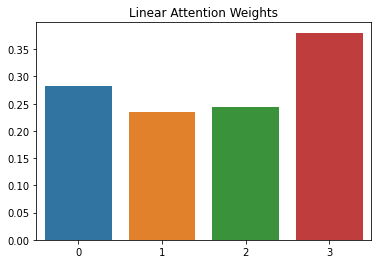

In [45]:
sns.barplot(np.arange(ncov),attention.weights.detach().cpu().numpy())
plt.title('Linear Attention Weights')
# plt.title('Attention Score')

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'True Event')

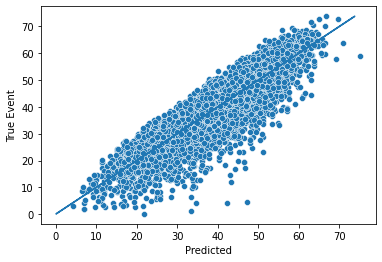

In [46]:
valid_e = torch.cat(valid_e)
valid_t = torch.cat(valid_t)
valid_pred_t = torch.cat(valid_pred_t)


subj = np.random.choice(len(valid_e))
plt.figure()

sns.scatterplot(valid_pred_t[valid_e==1].cpu().detach().numpy().squeeze(), valid_t[valid_e==1].cpu())
plt.plot(valid_t[valid_e==1].cpu(), valid_t[valid_e==1].cpu())
plt.xlabel('Predicted')
plt.ylabel('True Event')


In [28]:
# single head attention
# https://github.com/QiangAIResearcher/sahp_repo/blob/master/models/attention/single.py

import torch.nn as nn
import torch.nn.functional as F
import torch

import math
import numpy as np

class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """
    def forward(self, query, key, value, mask=None, dropout=None):

        # scores = torch.matmul(query, key.transpose(-2, -1)) \
        #          / math.sqrt(query.size(-1))
        
        # f(query, key)
        scores = torch.exp(torch.matmul(query, key.transpose(-2, -1))) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn
    
    
class MultiHeadedAttention(nn.Module):
    """
    Take in models size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model, bias=True) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model, bias=True)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # the same mask applies to all heads
            # unsqueeze Returns a new tensor with a dimension of size one
            # inserted at the specified position.
            mask = mask.unsqueeze(1)

        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention.forward(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

## define MLP network

In [52]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

class EncMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(EncMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        
    def forward(self, x):
        z = self.net(x)
        return z
    
class DecMLP_cts(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(DecMLP_cts, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
#         self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        return z

    
class DecMLP_clf(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(DecMLP_clf, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)
    
    
class SimpleMLP(nn.Module):
    def __init__(self, input_size=2, output_size=1, h_dim=[32,32]):
        super(SimpleMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)

In [53]:
n=10000
X = train['x']
# beta_linear = np.array([0.15,0.001])
# FX = np.dot(X,beta_linear).reshape((n,1))
t = train['t']
ncov = X.shape[1]
covList = np.arange(ncov)
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

trainData = SimpleDataset(X, t, train['e'], transform=True, mean=mean, std = std)
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(test['x'], test['t'], test['e'], transform=True, mean=mean, std = std)
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

NameError: name 'train' is not defined

In [51]:
ncov = X.shape[1]
zdim = 2
epochs = 1000
device = 'cpu'
# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128,128])

decoder = DecMLP_cts(input_size = zdim, output_size = 1, h_dim=[128,128])
# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-4)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)
enc_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'enc_only.pt'
dec_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'dec_only.pt'

print(encoder, decoder)

NameError: name 'X' is not defined

Text(0, 0.5, 'True Event')

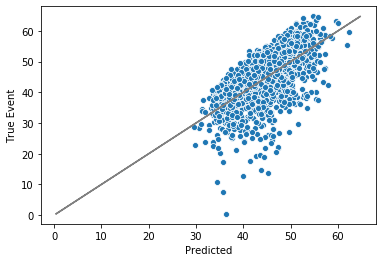

In [136]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

x = (torch.tensor(test['x']).to(device).float()-mean)/std
y = test['t']
e = test['e']
z = encoder(x.to(device).float())
t_hat = decoder(z)
sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
plt.plot(y[e==1], y[e==1], color='gray')

plt.xlabel('Predicted')
plt.ylabel('True Event')
# plt.xlim(min(t_hat.squeeze().detach()), max(y))
# plt.ylim(min(t_hat.squeeze().detach()), max(y))



Text(0, 0.5, 'True Event')

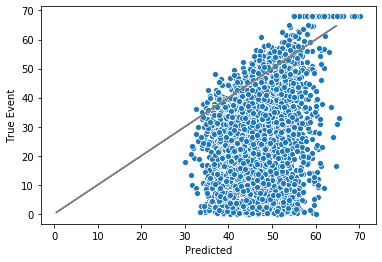

In [137]:
sns.scatterplot(t_hat[e==0].detach().numpy().squeeze(), y[e==0])
plt.plot(y[e==1], y[e==1], color='gray')

plt.xlabel('Predicted')
plt.ylabel('True Event')


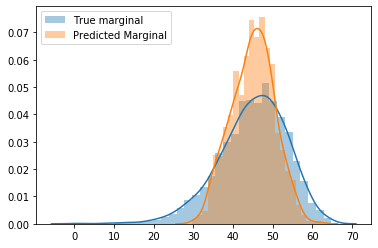

In [138]:
sns.distplot(y[e==1], label = 'True marginal')
sns.distplot(t_hat[e==1].detach().numpy(), label = 'Predicted Marginal')
plt.legend()

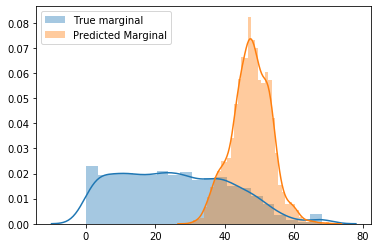

In [140]:
sns.distplot(y[e==0], label = 'True marginal')
sns.distplot(t_hat[e==0].detach().numpy(), label = 'Predicted Marginal')
plt.legend()

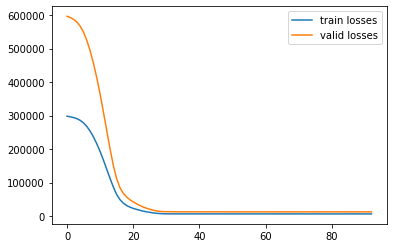

In [141]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()

In [73]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

encoder.eval()
decoder.eval()
x = (torch.tensor(test['x']).to(device).float()-mean)/std
z = encoder(x.to(device).float())
t = decoder(z)

calculate_KS_Div((x[test['e']==1,:]*std)+mean, p_raw[test['e']==1,:], tt), calculate_KS_Div((x*std)+mean, p_raw, tt)


NameError: name 'calculate_KS_Div' is not defined

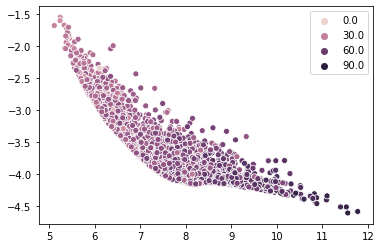

In [142]:
sns.scatterplot(z[:,0].detach(), z[:,1].detach(), hue=test['T'])

/Users/ZidiXiu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/ZidiXiu/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


(tensor(55.4096), tensor(1))

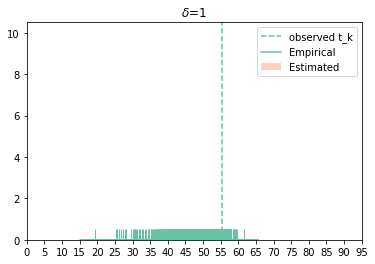

In [156]:
y = torch.tensor(test['t']).to(device).float()
e = torch.tensor(test['e']).to(device)
# y_cat = batch_t_categorize(y, e, tt)
x = (torch.tensor(test['x']).to(device).float()-mean)/std

subj = 6
x_new = x[subj,:].expand(100,-1)
z = encoder(x_new.to(device).float())
t_hat = decoder(z)


plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')
sns.distplot(t_hat.detach().numpy(), label='Estimated', color=pred_color)
# sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

plt.legend(loc='best')
plt.title(r'$\delta$='+str(e[subj].item()))
y[subj], e[subj]



## select pairs with data loader

In [159]:
for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):
    # PAIR 1 need to be non-censored ? +(1-e1)
    # y1 should not equal to y2
    delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
#     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
    x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
    x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]
    
    batch_label = 1*(y1 > y2)
    batch_pair = torch.cat([x1, x2],axis = 1)
    break

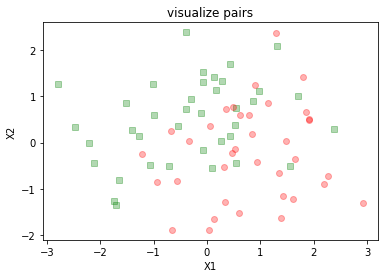

In [160]:
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)
_ = plt.title('visualize pairs')
_ = plt.plot(batch_pair[pos_idx,0].tolist(),batch_pair[pos_idx,ncov].tolist(),'sg',alpha=.3, label='T(X1)>T(X2)')
_ = plt.plot(batch_pair[neg_idx,0].tolist(),batch_pair[neg_idx,ncov].tolist(),'or',alpha=.3, label='T(X1)<T(X2)')

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

## Define the network

In [177]:
# if retrain encoder, decoder
ncov = X.shape[1]
zdim = 2
epochs = 1000
device = 'cpu'
# input is covariates 
# output is latent z
encoder = EncMLP(input_size = ncov, output_size = zdim, h_dim=[128,128])

decoder = DecMLP(input_size = zdim, output_size = 1, h_dim=[128,128])
# define optimizer
opt_enc = optim.Adam(encoder.parameters(), lr=1e-4)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)



hidden_layer=[128,128]
epochs = 1000
device = 'cpu'
# input is pair of X
clf = SimpleMLP(input_size = 2*zdim, output_size = 1, h_dim=hidden_layer)

# define optimizer
opt_clf = optim.Adam(clf.parameters(), lr=1e-4)

# define weight
ctr_wt = 1
clf_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'clf_'+str(ctr_wt)+'.pt'

enc_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'enc_'+str(ctr_wt)+'.pt'
dec_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'dec_'+str(ctr_wt)+'.pt'
print(encoder, decoder)
print(clf)


EncMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
) DecMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)
SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
  (out): Sigmoid()
)


In [178]:
def single_patient_true_surv_cox_gompertz(covariates, beta_linear = np.array([0.15,0.001]),lambda_=7e-8, alpha_=0.2138, n=1000,seed=123,tt=np.linspace(0,1,100)):
    
    X_age = covariates[0]
    X_randon = covariates[1]
    X_cts = [X_age, X_randon]     
    X = X_cts
    St = np.exp(-(lambda_/alpha_)*(np.exp(alpha_*tt)-1)*np.exp(np.dot(X,beta_linear)))
    return({"St": St})

# KS divergence
def KS_D(F1, F2, tt):
    diff_list = np.abs((np.ones(len(tt))-F1)-(np.ones(len(tt))-F2))
    return(tt[np.argmax(diff_list)], np.max(diff_list), diff_list)

def calculate_KS_Div(x, p_raw, tt):
    KS_list = []
    for subj in np.arange(p_raw.shape[0]):
        true_St=single_patient_true_surv_cox_gompertz(covariates=x[subj,:].numpy(), tt=tt)['St']
        St = 1-np.cumsum(p_raw[subj,:].detach().numpy())
        diff_t, diff_D, diff_list = KS_D(St, true_St, tt)
        KS_list.append(diff_D)

    return np.mean(KS_list)

epoch1
====> Train Loss: 598019.7891 	 NLL: 598019.0964 	 contrastive loss: 0.6927
====> Valid NLL loss: 597951.3697 	Improved: *
epoch2
====> Train Loss: 594047.0299 	 NLL: 594046.3373 	 contrastive loss: 0.6926
====> Valid NLL loss: 593967.2894 	Improved: *
epoch3
====> Train Loss: 589606.2762 	 NLL: 589605.5859 	 contrastive loss: 0.6904
====> Valid NLL loss: 588863.4839 	Improved: *
epoch4
====> Train Loss: 583396.0191 	 NLL: 583395.3324 	 contrastive loss: 0.6866
====> Valid NLL loss: 581354.4926 	Improved: *
epoch5
====> Train Loss: 574136.1998 	 NLL: 574135.5143 	 contrastive loss: 0.6854
====> Valid NLL loss: 570171.2735 	Improved: *
epoch6
====> Train Loss: 560883.1960 	 NLL: 560882.5164 	 contrastive loss: 0.6796
====> Valid NLL loss: 554962.1832 	Improved: *
epoch7
====> Train Loss: 543442.8007 	 NLL: 543442.1210 	 contrastive loss: 0.6797
====> Valid NLL loss: 535245.0540 	Improved: *
epoch8
====> Train Loss: 521175.5906 	 NLL: 521174.9125 	 contrastive loss: 0.6781
====> V

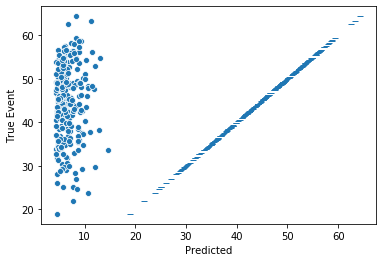

====> Valid NLL loss: 443585.2255 	Improved: *
epoch11
====> Train Loss: 420164.6468 	 NLL: 420163.9572 	 contrastive loss: 0.6896
====> Valid NLL loss: 401766.9092 	Improved: *
epoch12
====> Train Loss: 374934.3770 	 NLL: 374933.6866 	 contrastive loss: 0.6904
====> Valid NLL loss: 354130.7078 	Improved: *
epoch13
====> Train Loss: 324830.3126 	 NLL: 324829.6137 	 contrastive loss: 0.6989
====> Valid NLL loss: 301821.9226 	Improved: *
epoch14
====> Train Loss: 270542.3757 	 NLL: 270541.6795 	 contrastive loss: 0.6961
====> Valid NLL loss: 246452.3501 	Improved: *
epoch15
====> Train Loss: 214540.7464 	 NLL: 214540.0440 	 contrastive loss: 0.7024
====> Valid NLL loss: 189844.9166 	Improved: *
epoch16
====> Train Loss: 159721.3941 	 NLL: 159720.7027 	 contrastive loss: 0.6914
====> Valid NLL loss: 136861.0703 	Improved: *
epoch17
====> Train Loss: 111336.2215 	 NLL: 111335.5248 	 contrastive loss: 0.6967
====> Valid NLL loss: 92870.5845 	Improved: *
epoch18
====> Train Loss: 75672.8004 

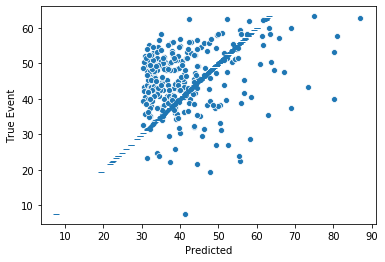

====> Valid NLL loss: 42338.0001 	Improved: *
epoch21
====> Train Loss: 40003.0587 	 NLL: 40002.4144 	 contrastive loss: 0.6443
====> Valid NLL loss: 35756.5713 	Improved: *
epoch22
====> Train Loss: 34202.7668 	 NLL: 34202.1356 	 contrastive loss: 0.6312
====> Valid NLL loss: 30925.7458 	Improved: *
epoch23
====> Train Loss: 29414.3942 	 NLL: 29413.7891 	 contrastive loss: 0.6052
====> Valid NLL loss: 26442.2598 	Improved: *
epoch24
====> Train Loss: 25343.0441 	 NLL: 25342.4597 	 contrastive loss: 0.5843
====> Valid NLL loss: 22554.2147 	Improved: *
epoch25
====> Train Loss: 21688.4007 	 NLL: 21687.8271 	 contrastive loss: 0.5736
====> Valid NLL loss: 19419.3841 	Improved: *
epoch26
====> Train Loss: 18724.4195 	 NLL: 18723.8701 	 contrastive loss: 0.5494
====> Valid NLL loss: 16684.5260 	Improved: *
epoch27
====> Train Loss: 16354.2513 	 NLL: 16353.7213 	 contrastive loss: 0.5300
====> Valid NLL loss: 14846.8080 	Improved: *
epoch28
====> Train Loss: 14719.5111 	 NLL: 14718.9951 	 c

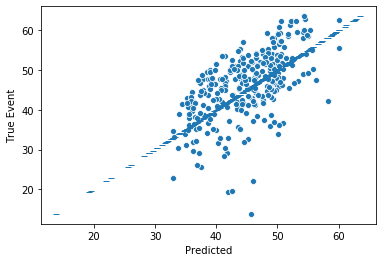

====> Valid NLL loss: 13177.1507 	Improved: *
epoch31
====> Train Loss: 13505.7222 	 NLL: 13505.2616 	 contrastive loss: 0.4606
====> Valid NLL loss: 13094.6500 	Improved: *
epoch32
====> Train Loss: 13543.8405 	 NLL: 13543.3762 	 contrastive loss: 0.4643
====> Valid NLL loss: 13019.2507 	Improved: *
epoch33
====> Train Loss: 13423.6661 	 NLL: 13423.2327 	 contrastive loss: 0.4335
====> Valid NLL loss: 12920.3799 	Improved: *
epoch34
====> Train Loss: 13384.7042 	 NLL: 13384.2586 	 contrastive loss: 0.4455
====> Valid NLL loss: 12925.0167 	Improved:  
epoch35
====> Train Loss: 13342.0673 	 NLL: 13341.6349 	 contrastive loss: 0.4324
====> Valid NLL loss: 12906.3424 	Improved: *
epoch36
====> Train Loss: 13323.9790 	 NLL: 13323.5160 	 contrastive loss: 0.4630
====> Valid NLL loss: 12832.8989 	Improved: *
epoch37
====> Train Loss: 13274.1347 	 NLL: 13273.6813 	 contrastive loss: 0.4534
====> Valid NLL loss: 12865.5729 	Improved:  
epoch38
====> Train Loss: 13272.0883 	 NLL: 13271.6599 	 c

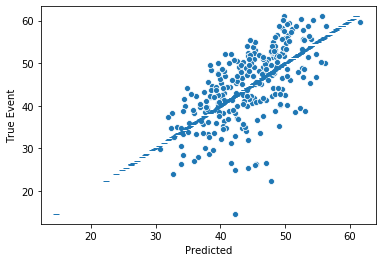

====> Valid NLL loss: 12859.1196 	Improved:  
epoch41
====> Train Loss: 13220.9757 	 NLL: 13220.5458 	 contrastive loss: 0.4299
====> Valid NLL loss: 12951.9346 	Improved:  
epoch42
====> Train Loss: 13225.6749 	 NLL: 13225.2266 	 contrastive loss: 0.4483
====> Valid NLL loss: 12818.2862 	Improved: *
epoch43
====> Train Loss: 13279.9613 	 NLL: 13279.5194 	 contrastive loss: 0.4420
====> Valid NLL loss: 12762.1877 	Improved: *
epoch44
====> Train Loss: 13176.2616 	 NLL: 13175.8109 	 contrastive loss: 0.4507
====> Valid NLL loss: 12773.9132 	Improved:  
epoch45
====> Train Loss: 13170.0187 	 NLL: 13169.5752 	 contrastive loss: 0.4436
====> Valid NLL loss: 12824.4867 	Improved:  
epoch46
====> Train Loss: 13168.9664 	 NLL: 13168.5430 	 contrastive loss: 0.4234
====> Valid NLL loss: 12765.5885 	Improved:  
epoch47
====> Train Loss: 13148.9148 	 NLL: 13148.4844 	 contrastive loss: 0.4304
====> Valid NLL loss: 12794.9337 	Improved:  
epoch48
====> Train Loss: 13143.3875 	 NLL: 13142.9708 	 c

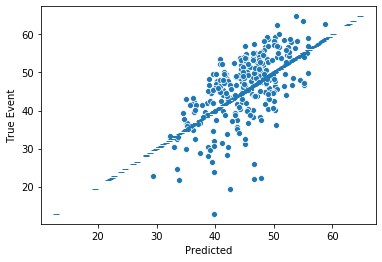

====> Valid NLL loss: 12835.9686 	Improved:  
epoch51
====> Train Loss: 13138.1506 	 NLL: 13137.7252 	 contrastive loss: 0.4254
====> Valid NLL loss: 12725.9454 	Improved: *
epoch52
====> Train Loss: 13111.8537 	 NLL: 13111.4002 	 contrastive loss: 0.4535
====> Valid NLL loss: 12722.2071 	Improved: *
epoch53
====> Train Loss: 13111.7381 	 NLL: 13111.2930 	 contrastive loss: 0.4451
====> Valid NLL loss: 12729.1283 	Improved:  
epoch54
====> Train Loss: 13132.6492 	 NLL: 13132.2242 	 contrastive loss: 0.4250
====> Valid NLL loss: 12771.4539 	Improved:  
epoch55
====> Train Loss: 13107.8243 	 NLL: 13107.3813 	 contrastive loss: 0.4430
====> Valid NLL loss: 12721.1712 	Improved: *
epoch56
====> Train Loss: 13135.3618 	 NLL: 13134.9311 	 contrastive loss: 0.4307
====> Valid NLL loss: 12738.0711 	Improved:  
epoch57
====> Train Loss: 13138.6031 	 NLL: 13138.1878 	 contrastive loss: 0.4153
====> Valid NLL loss: 12754.5380 	Improved:  
epoch58
====> Train Loss: 13107.0987 	 NLL: 13106.6747 	 c

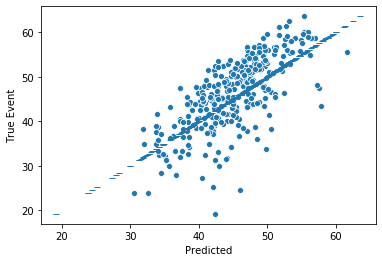

====> Valid NLL loss: 12722.0240 	Improved:  
epoch61
====> Train Loss: 13150.5374 	 NLL: 13150.1199 	 contrastive loss: 0.4175
====> Valid NLL loss: 12868.2655 	Improved:  
epoch62
====> Train Loss: 13128.3587 	 NLL: 13127.9362 	 contrastive loss: 0.4225
====> Valid NLL loss: 12835.4688 	Improved:  
epoch63
====> Train Loss: 13156.6407 	 NLL: 13156.1849 	 contrastive loss: 0.4558
====> Valid NLL loss: 12775.3208 	Improved:  
epoch64
====> Train Loss: 13116.1991 	 NLL: 13115.7611 	 contrastive loss: 0.4380
====> Valid NLL loss: 12756.9529 	Improved:  
epoch65
====> Train Loss: 13071.6303 	 NLL: 13071.1878 	 contrastive loss: 0.4425
====> Valid NLL loss: 12811.6858 	Improved:  
epoch66
====> Train Loss: 13142.0779 	 NLL: 13141.6618 	 contrastive loss: 0.4161
====> Valid NLL loss: 12745.9660 	Improved:  
epoch67
====> Train Loss: 13093.7162 	 NLL: 13093.2862 	 contrastive loss: 0.4299
====> Valid NLL loss: 12748.4260 	Improved:  
epoch68
====> Train Loss: 13091.8983 	 NLL: 13091.4484 	 c

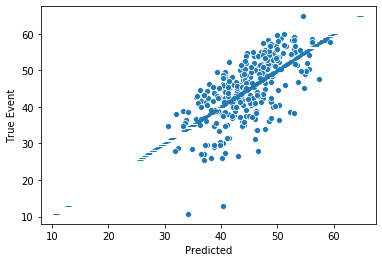

====> Valid NLL loss: 12731.0398 	Improved:  
epoch71
====> Train Loss: 13077.5687 	 NLL: 13077.1287 	 contrastive loss: 0.4400
====> Valid NLL loss: 12737.7116 	Improved:  
epoch72
====> Train Loss: 13076.2160 	 NLL: 13075.7758 	 contrastive loss: 0.4402
====> Valid NLL loss: 12770.8685 	Improved:  
epoch73
====> Train Loss: 13073.7884 	 NLL: 13073.3466 	 contrastive loss: 0.4418
====> Valid NLL loss: 12727.8262 	Improved:  
epoch74
====> Train Loss: 13077.3815 	 NLL: 13076.9625 	 contrastive loss: 0.4190
====> Valid NLL loss: 12765.2236 	Improved:  
epoch75
====> Train Loss: 13087.9939 	 NLL: 13087.5644 	 contrastive loss: 0.4295
====> Valid NLL loss: 12810.7804 	Improved:  
epoch76
====> Train Loss: 13104.9230 	 NLL: 13104.4807 	 contrastive loss: 0.4422
====> Valid NLL loss: 12771.3601 	Improved:  
epoch77
====> Train Loss: 13127.6548 	 NLL: 13127.2184 	 contrastive loss: 0.4364
====> Valid NLL loss: 12727.9086 	Improved:  
epoch78
====> Train Loss: 13111.4183 	 NLL: 13110.9807 	 c

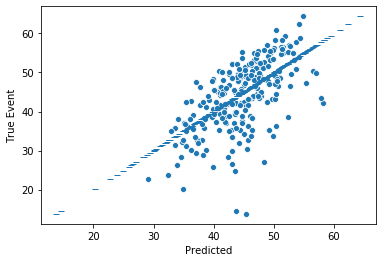

====> Valid NLL loss: 12724.3933 	Improved:  
epoch81
====> Train Loss: 13061.8460 	 NLL: 13061.3974 	 contrastive loss: 0.4486
====> Valid NLL loss: 12731.6868 	Improved:  
epoch82
====> Train Loss: 13056.2522 	 NLL: 13055.8364 	 contrastive loss: 0.4159
====> Valid NLL loss: 12730.0449 	Improved:  
epoch83
====> Train Loss: 13086.2539 	 NLL: 13085.8219 	 contrastive loss: 0.4320
====> Valid NLL loss: 12722.6596 	Improved:  
epoch84
====> Train Loss: 13057.1914 	 NLL: 13056.7831 	 contrastive loss: 0.4083
====> Valid NLL loss: 12759.3006 	Improved:  
epoch85
====> Train Loss: 13045.6148 	 NLL: 13045.1647 	 contrastive loss: 0.4502
====> Valid NLL loss: 12743.8962 	Improved:  
epoch86
====> Train Loss: 13049.2473 	 NLL: 13048.8090 	 contrastive loss: 0.4383
====> Valid NLL loss: 12722.0114 	Improved:  
epoch87
====> Train Loss: 13060.7456 	 NLL: 13060.3080 	 contrastive loss: 0.4376
====> Valid NLL loss: 12770.5181 	Improved:  
epoch88
====> Train Loss: 13063.7471 	 NLL: 13063.3050 	 c

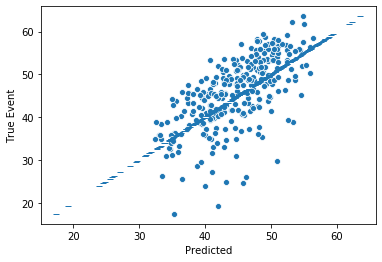

====> Valid NLL loss: 12769.4634 	Improved:  
epoch91
====> Train Loss: 13047.0298 	 NLL: 13046.5940 	 contrastive loss: 0.4358
====> Valid NLL loss: 12713.6341 	Improved: *
epoch92
====> Train Loss: 13052.9826 	 NLL: 13052.5488 	 contrastive loss: 0.4339
====> Valid NLL loss: 12711.4939 	Improved: *
epoch93
====> Train Loss: 13053.4693 	 NLL: 13053.0642 	 contrastive loss: 0.4051
====> Valid NLL loss: 12713.3494 	Improved:  
epoch94
====> Train Loss: 13044.3930 	 NLL: 13043.9609 	 contrastive loss: 0.4321
====> Valid NLL loss: 12812.6387 	Improved:  
epoch95
====> Train Loss: 13067.8431 	 NLL: 13067.4030 	 contrastive loss: 0.4401
====> Valid NLL loss: 12730.2543 	Improved:  
epoch96
====> Train Loss: 13060.8590 	 NLL: 13060.4204 	 contrastive loss: 0.4385
====> Valid NLL loss: 12716.9933 	Improved:  
epoch97
====> Train Loss: 13056.2686 	 NLL: 13055.8173 	 contrastive loss: 0.4512
====> Valid NLL loss: 12733.1271 	Improved:  
epoch98
====> Train Loss: 13063.3422 	 NLL: 13062.9008 	 c

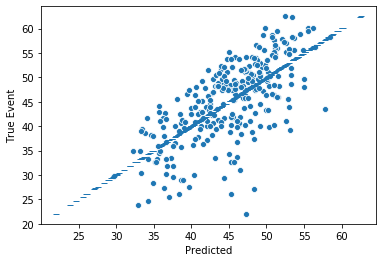

====> Valid NLL loss: 12733.7970 	Improved:  
epoch101
====> Train Loss: 13052.4548 	 NLL: 13052.0503 	 contrastive loss: 0.4045
====> Valid NLL loss: 12714.1316 	Improved:  
epoch102
====> Train Loss: 13061.8613 	 NLL: 13061.4265 	 contrastive loss: 0.4348
====> Valid NLL loss: 12719.1677 	Improved:  
epoch103
====> Train Loss: 13039.1456 	 NLL: 13038.7035 	 contrastive loss: 0.4420
====> Valid NLL loss: 12781.1753 	Improved:  
epoch104
====> Train Loss: 13048.1370 	 NLL: 13047.6974 	 contrastive loss: 0.4397
====> Valid NLL loss: 12748.8731 	Improved:  
epoch105
====> Train Loss: 13049.8632 	 NLL: 13049.4425 	 contrastive loss: 0.4207
====> Valid NLL loss: 12746.8474 	Improved:  
epoch106
====> Train Loss: 13049.5661 	 NLL: 13049.1342 	 contrastive loss: 0.4319
====> Valid NLL loss: 12719.6019 	Improved:  
epoch107
====> Train Loss: 13087.0904 	 NLL: 13086.6635 	 contrastive loss: 0.4269
====> Valid NLL loss: 12740.0475 	Improved:  
epoch108
====> Train Loss: 13051.0923 	 NLL: 13050.

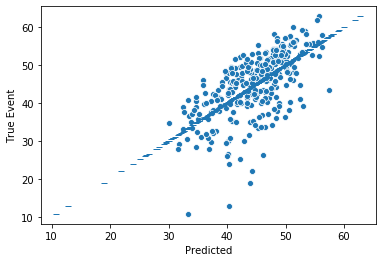

====> Valid NLL loss: 12729.3689 	Improved:  
epoch111
====> Train Loss: 13035.5777 	 NLL: 13035.1185 	 contrastive loss: 0.4592
====> Valid NLL loss: 12740.4515 	Improved:  
epoch112
====> Train Loss: 13060.3620 	 NLL: 13059.9474 	 contrastive loss: 0.4146
====> Valid NLL loss: 12729.8343 	Improved:  
epoch113
====> Train Loss: 13088.5834 	 NLL: 13088.1448 	 contrastive loss: 0.4386
====> Valid NLL loss: 13125.3151 	Improved:  
epoch114
====> Train Loss: 13135.6957 	 NLL: 13135.2858 	 contrastive loss: 0.4099
====> Valid NLL loss: 12805.1062 	Improved:  
epoch115
====> Train Loss: 13060.0642 	 NLL: 13059.6227 	 contrastive loss: 0.4415
====> Valid NLL loss: 12755.2794 	Improved:  
epoch116
====> Train Loss: 13051.0426 	 NLL: 13050.5870 	 contrastive loss: 0.4556
====> Valid NLL loss: 12731.2745 	Improved:  
epoch117
====> Train Loss: 13027.8330 	 NLL: 13027.3883 	 contrastive loss: 0.4447
====> Valid NLL loss: 12757.4770 	Improved:  
epoch118
====> Train Loss: 13051.4616 	 NLL: 13051.

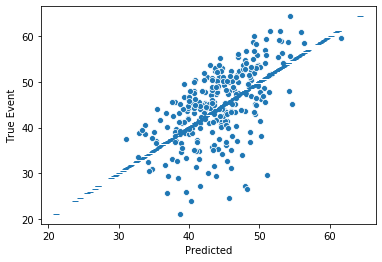

====> Valid NLL loss: 12738.1924 	Improved:  
epoch121
====> Train Loss: 13024.7337 	 NLL: 13024.2969 	 contrastive loss: 0.4368
====> Valid NLL loss: 12762.4697 	Improved:  
epoch122
====> Train Loss: 13036.5841 	 NLL: 13036.1480 	 contrastive loss: 0.4360
====> Valid NLL loss: 12733.9582 	Improved:  
epoch123
====> Train Loss: 13024.5396 	 NLL: 13024.1286 	 contrastive loss: 0.4110
====> Valid NLL loss: 12761.9589 	Improved:  
epoch124
====> Train Loss: 13021.1104 	 NLL: 13020.6761 	 contrastive loss: 0.4343
====> Valid NLL loss: 12748.3884 	Improved:  
epoch125
====> Train Loss: 13022.3729 	 NLL: 13021.9593 	 contrastive loss: 0.4136
====> Valid NLL loss: 12756.8110 	Improved:  
epoch126
====> Train Loss: 13015.0091 	 NLL: 13014.5807 	 contrastive loss: 0.4284
====> Valid NLL loss: 12719.7755 	Improved:  
epoch127
====> Train Loss: 13048.8858 	 NLL: 13048.4436 	 contrastive loss: 0.4422
====> Valid NLL loss: 12731.9616 	Improved:  
epoch128
====> Train Loss: 13041.4858 	 NLL: 13041.

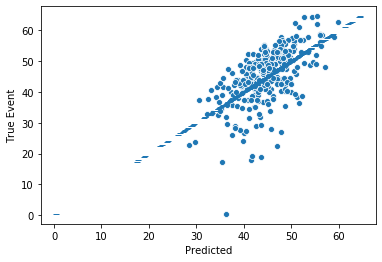

====> Valid NLL loss: 12784.7861 	Improved:  
epoch131
====> Train Loss: 13067.9203 	 NLL: 13067.4851 	 contrastive loss: 0.4352
====> Valid NLL loss: 12814.3798 	Improved:  
epoch132
====> Train Loss: 13030.2880 	 NLL: 13029.8742 	 contrastive loss: 0.4138
====> Valid NLL loss: 12788.0919 	Improved:  
epoch133
====> Train Loss: 13038.3311 	 NLL: 13037.8872 	 contrastive loss: 0.4439
====> Valid NLL loss: 12793.5724 	Improved:  
epoch134
====> Train Loss: 13038.9755 	 NLL: 13038.5322 	 contrastive loss: 0.4433
====> Valid NLL loss: 12725.0740 	Improved:  
epoch135
====> Train Loss: 13028.4768 	 NLL: 13028.0335 	 contrastive loss: 0.4433
====> Valid NLL loss: 12747.7600 	Improved:  
epoch136
====> Train Loss: 13008.5013 	 NLL: 13008.0740 	 contrastive loss: 0.4273
====> Valid NLL loss: 12725.5353 	Improved:  
epoch137
====> Train Loss: 13032.9575 	 NLL: 13032.5341 	 contrastive loss: 0.4235
====> Valid NLL loss: 12781.3488 	Improved:  
epoch138
====> Train Loss: 13040.7918 	 NLL: 13040.

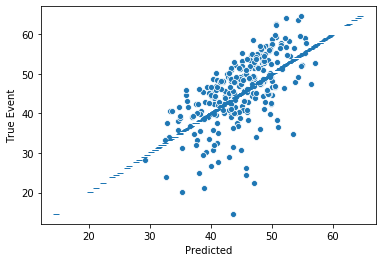

====> Valid NLL loss: 12747.5087 	Improved:  
epoch141
====> Train Loss: 13036.5761 	 NLL: 13036.1351 	 contrastive loss: 0.4410
====> Valid NLL loss: 12747.5475 	Improved:  
epoch142
====> Train Loss: 13012.4228 	 NLL: 13012.0163 	 contrastive loss: 0.4066
====> Valid NLL loss: 12706.6968 	Improved: *
epoch143
====> Train Loss: 13020.8392 	 NLL: 13020.4082 	 contrastive loss: 0.4310
====> Valid NLL loss: 12737.4249 	Improved:  
epoch144
====> Train Loss: 13008.8322 	 NLL: 13008.4056 	 contrastive loss: 0.4266
====> Valid NLL loss: 12711.0038 	Improved:  
epoch145
====> Train Loss: 13015.3056 	 NLL: 13014.8569 	 contrastive loss: 0.4486
====> Valid NLL loss: 12715.6097 	Improved:  
epoch146
====> Train Loss: 13018.3110 	 NLL: 13017.8974 	 contrastive loss: 0.4136
====> Valid NLL loss: 12727.4561 	Improved:  
epoch147
====> Train Loss: 13030.0922 	 NLL: 13029.6383 	 contrastive loss: 0.4539
====> Valid NLL loss: 12740.4881 	Improved:  
epoch148
====> Train Loss: 13026.2466 	 NLL: 13025.

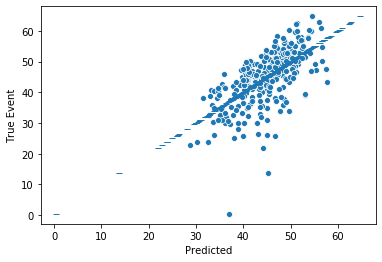

====> Valid NLL loss: 12739.2495 	Improved:  
epoch151
====> Train Loss: 13009.1714 	 NLL: 13008.7278 	 contrastive loss: 0.4436
====> Valid NLL loss: 12745.6999 	Improved:  
epoch152
====> Train Loss: 13060.1642 	 NLL: 13059.7434 	 contrastive loss: 0.4208
====> Valid NLL loss: 12724.9632 	Improved:  
epoch153
====> Train Loss: 13043.2361 	 NLL: 13042.8127 	 contrastive loss: 0.4234
====> Valid NLL loss: 12878.1238 	Improved:  
epoch154
====> Train Loss: 13038.3472 	 NLL: 13037.8841 	 contrastive loss: 0.4631
====> Valid NLL loss: 12736.6392 	Improved:  
epoch155
====> Train Loss: 13017.7028 	 NLL: 13017.2534 	 contrastive loss: 0.4494
====> Valid NLL loss: 12838.8231 	Improved:  
epoch156
====> Train Loss: 13043.3878 	 NLL: 13042.9857 	 contrastive loss: 0.4022
====> Valid NLL loss: 12762.7838 	Improved:  
epoch157
====> Train Loss: 13026.9848 	 NLL: 13026.5405 	 contrastive loss: 0.4443
====> Valid NLL loss: 12785.0023 	Improved:  
epoch158
====> Train Loss: 12988.4405 	 NLL: 12988.

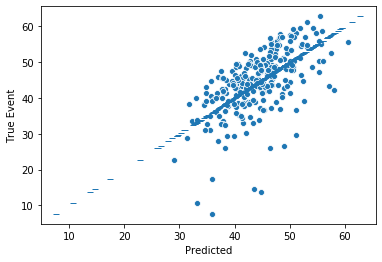

====> Valid NLL loss: 12765.7623 	Improved:  
epoch161
====> Train Loss: 13013.8832 	 NLL: 13013.4626 	 contrastive loss: 0.4206
====> Valid NLL loss: 12757.2912 	Improved:  
epoch162
====> Train Loss: 13026.2607 	 NLL: 13025.8136 	 contrastive loss: 0.4471
====> Valid NLL loss: 12738.8841 	Improved:  
epoch163
====> Train Loss: 13058.5776 	 NLL: 13058.1477 	 contrastive loss: 0.4299
====> Valid NLL loss: 12731.0131 	Improved:  
epoch164
====> Train Loss: 13007.3353 	 NLL: 13006.8815 	 contrastive loss: 0.4538
====> Valid NLL loss: 12741.7628 	Improved:  
epoch165
====> Train Loss: 13021.3738 	 NLL: 13020.9298 	 contrastive loss: 0.4441
====> Valid NLL loss: 12733.1938 	Improved:  
epoch166
====> Train Loss: 13027.9780 	 NLL: 13027.5494 	 contrastive loss: 0.4286
====> Valid NLL loss: 12720.6022 	Improved:  
epoch167
====> Train Loss: 13004.0276 	 NLL: 13003.5837 	 contrastive loss: 0.4439
====> Valid NLL loss: 12743.5851 	Improved:  
epoch168
====> Train Loss: 13005.4663 	 NLL: 13005.

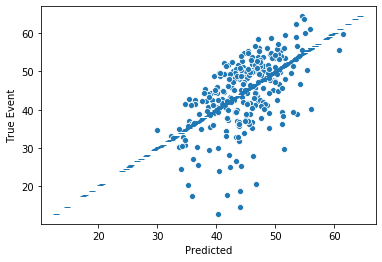

====> Valid NLL loss: 12713.8450 	Improved:  
epoch171
====> Train Loss: 13000.1278 	 NLL: 12999.7087 	 contrastive loss: 0.4192
====> Valid NLL loss: 12710.7473 	Improved:  
epoch172
====> Train Loss: 13013.5941 	 NLL: 13013.1637 	 contrastive loss: 0.4304
====> Valid NLL loss: 12810.1296 	Improved:  
epoch173
====> Train Loss: 13042.4473 	 NLL: 13041.9987 	 contrastive loss: 0.4487
====> Valid NLL loss: 12745.7766 	Improved:  
epoch174
====> Train Loss: 13021.0746 	 NLL: 13020.6147 	 contrastive loss: 0.4599
====> Valid NLL loss: 12714.2188 	Improved:  
epoch175
====> Train Loss: 13013.7596 	 NLL: 13013.3285 	 contrastive loss: 0.4311
====> Valid NLL loss: 12722.9236 	Improved:  
epoch176
====> Train Loss: 12984.9184 	 NLL: 12984.4757 	 contrastive loss: 0.4427
====> Valid NLL loss: 12804.7836 	Improved:  
epoch177
====> Train Loss: 13002.6678 	 NLL: 13002.2197 	 contrastive loss: 0.4481
====> Valid NLL loss: 12744.5712 	Improved:  
epoch178
====> Train Loss: 13009.8444 	 NLL: 13009.

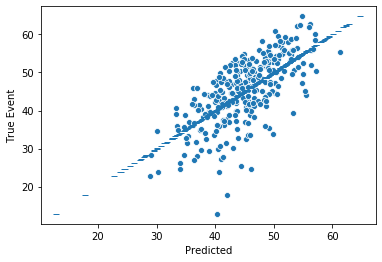

====> Valid NLL loss: 12734.3433 	Improved:  
epoch181
====> Train Loss: 13011.0712 	 NLL: 13010.6276 	 contrastive loss: 0.4436
====> Valid NLL loss: 12745.3336 	Improved:  
epoch182
====> Train Loss: 13037.0578 	 NLL: 13036.6320 	 contrastive loss: 0.4258
====> Valid NLL loss: 12747.2819 	Improved:  
epoch183
====> Train Loss: 12997.5006 	 NLL: 12997.0799 	 contrastive loss: 0.4207
====> Valid NLL loss: 12714.1267 	Improved:  
epoch184
====> Train Loss: 13018.0572 	 NLL: 13017.6178 	 contrastive loss: 0.4393
====> Valid NLL loss: 12744.8746 	Improved:  
epoch185
====> Train Loss: 13009.0862 	 NLL: 13008.6630 	 contrastive loss: 0.4232
====> Valid NLL loss: 12757.7515 	Improved:  
epoch186
====> Train Loss: 12998.8919 	 NLL: 12998.4601 	 contrastive loss: 0.4317
====> Valid NLL loss: 12741.2308 	Improved:  
epoch187
====> Train Loss: 12994.5166 	 NLL: 12994.0951 	 contrastive loss: 0.4215
====> Valid NLL loss: 12772.4112 	Improved:  
epoch188
====> Train Loss: 13004.3899 	 NLL: 13003.

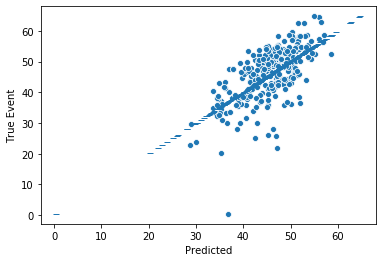

====> Valid NLL loss: 12744.9768 	Improved:  
epoch191
====> Train Loss: 13014.8920 	 NLL: 13014.4679 	 contrastive loss: 0.4241
====> Valid NLL loss: 12722.2676 	Improved:  
epoch192
====> Train Loss: 13007.6557 	 NLL: 13007.2138 	 contrastive loss: 0.4419
====> Valid NLL loss: 12865.7948 	Improved:  
Model stopped due to early stopping


In [179]:
best_valid_loss = np.inf
best_epoch = 0
# encoder.load_state_dict(torch.load(enc_path))
# decoder.load_state_dict(torch.load(dec_path))

train_loss_hist = []
train_rec_hist = []
train_ctr_hist = []

valid_loss_hist = []

ctr_learning = True
for epoch in range(1, epochs + 1):


    train_loss = 0
    rec_loss = 0
    ctr_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "

    
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):
#         print(i)
        # training encoder and decoder
        
        x = torch.cat([x1,x2]).to(device).float()
        y = torch.cat([y1,y2])
        e = torch.cat([e1,e2])
                
        if not ctr_learning:
            ctr_wt = 0
            
        clf.train()
        encoder.train()
        decoder.train()
        z = encoder(x)
        # exclude right censored subjects when training decoder
#             p_raw = decoder(z)

#             y_cat = batch_t_categorize(y, e, tt)
#             keep_idx = np.arange(len(e))

#             y_loglikeli = -((p_raw[keep_idx,:]*torch.tensor(y_cat[keep_idx,:])).sum(axis=1)+1e-6).log().mean()

        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss).squeeze()).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
        rec_loss_ = closs + eloss


        # contrastive learning step
        delete_loc = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
        keep_idx_1 = torch.where(delete_loc==0)[0]
        keep_idx_2 = keep_idx_1+len(e1)

        batch_label = (1*(y[keep_idx_1] > y[keep_idx_2])).to(device).squeeze().float()

        batch_pair = torch.cat([z[keep_idx_1], z[keep_idx_2]],axis = 1).to(device).float()

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        contrastive_loss = BCEloss(pred_label.squeeze(), batch_label.float())

        loss = rec_loss_ + ctr_wt*contrastive_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1e-4)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-4)
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-3)

        train_loss += loss.item()
        rec_loss += rec_loss_.item()
        ctr_loss += contrastive_loss.item()

        opt_enc.step()  
        opt_dec.step()  
        opt_clf.step()          

        
    train_loss = train_loss/(i+1)
    rec_loss = rec_loss/(i+1) 
    ctr_loss = ctr_loss/(i+1)  

    print('====> Train Loss: {:.4f} \t NLL: {:.4f} \t contrastive loss: {:.4f}'.format(train_loss, rec_loss, ctr_loss))
    
    encoder.eval()
    decoder.eval()
    clf.eval()
    
    valid_loss = 0
    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        
        z = encoder(x)
        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss).squeeze()).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()

        valid_loss_ = eloss.item()

        valid_loss += valid_loss_


    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    train_rec_hist.append(rec_loss)
    train_ctr_hist.append(ctr_loss)
    valid_loss_hist.append(valid_loss)
    
    if epoch % 10 == 0:
        
        sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
        plt.plot(y[e==1], y[e==1])
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
#         plt.xlim(min(y), max(y))
#         plt.ylim(min(y), max(y))
        
#         subj = np.random.choice(len(e))
#         plt.figure()

#         plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

#         sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
#         true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
#         sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
#         plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.
                
#         plt.title(r'$\delta$='+str(e[subj].item()))

        plt.show()

    save_model = 0
    if (best_valid_loss > valid_loss):
        save_model += 1

    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss
        torch.save(encoder.state_dict(), enc_path)
        torch.save(decoder.state_dict(), dec_path)
        torch.save(clf.state_dict(), clf_path)

        improved_str = "*"
    print('====> Valid NLL loss: {:.4f} \tImproved: {}'.format(valid_loss, improved_str))

#     if ctr_learning and (epoch - best_epoch >=20):
#         ctr_learning = False
#         print('Contrastive learning stopped')
    
#     if not ctr_learning and (epoch - best_epoch >=50):
#         print('Model stopped due to early stopping')
#         break
    if (epoch - best_epoch >=50):
        print('Model stopped due to early stopping')
        break        

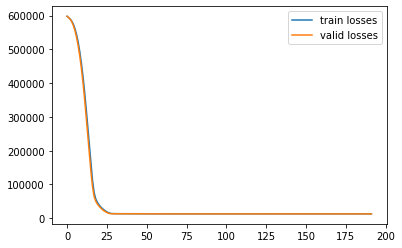

In [180]:
plt.plot(train_rec_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
# stop_ctr = train_ctr_hist.index(0)
# plt.axvline(stop_ctr,linestyle='--',color=emp_color,label='stop \ncontrastive \nlearning')

plt.legend()

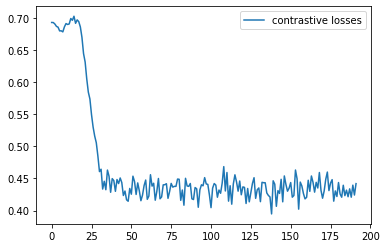

In [181]:
plt.plot(train_ctr_hist,label="contrastive losses")
plt.legend()

In [182]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))
for i, (x, y, e) in enumerate(pair1):
    break
enc_path, dec_path

('/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/enc_1.pt',
 '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/dec_1.pt')

Text(0, 0.5, 'True Event')

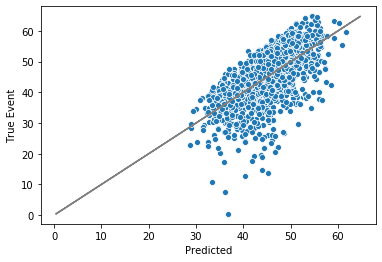

In [183]:
encoder.eval()
decoder.eval()
x = (torch.tensor(test['x']).to(device).float()-mean)/std
y = test['t']
e = test['e']
z = encoder(x.to(device).float())
t_hat = decoder(z)
sns.scatterplot(t_hat[e==1].detach().numpy().squeeze(), y[e==1])
plt.plot(y[e==1], y[e==1], color='gray')
plt.xlabel('Predicted')
plt.ylabel('True Event')
# plt.xlim(min(t_hat.squeeze().detach()), max(y))
# plt.ylim(min(t_hat.squeeze().detach()), max(y))

Text(0, 0.5, 'True Event')

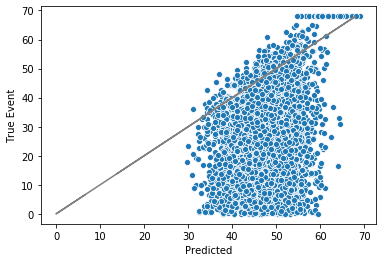

In [186]:
sns.scatterplot(t_hat[e==0].detach().numpy().squeeze(), y[e==0])
plt.plot(y[e==0], y[e==0], color='gray')
plt.xlabel('Predicted')
plt.ylabel('True Event')


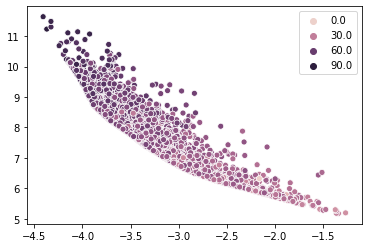

In [185]:
sns.scatterplot(z[:,0].detach(), z[:,1].detach(), hue=test['T'])

In [820]:
# torch.where(e==1),
np.where(test['t']>t_max)

(array([  17,   19,  105,  198,  348,  472,  743,  749,  940, 1009, 1085,
        1180, 1209, 1438, 1504, 1565, 1825, 1951, 2096, 2120, 2251, 2499,
        2555, 2775, 3088, 3090, 3246, 3305, 3338, 3923, 4054, 4202, 4252,
        4298, 4317, 4318, 4357, 4373, 4511, 4626, 4678, 4772, 4970]),)

(tensor(68.), tensor(0))

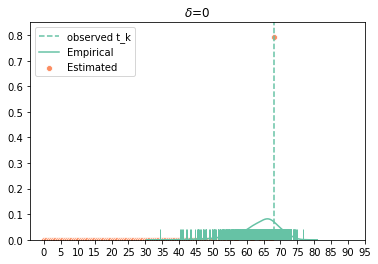

In [825]:
encoder.load_state_dict(torch.load(enc_path))
decoder.load_state_dict(torch.load(dec_path))

y = torch.tensor(test['t']).to(device).float()
e = torch.tensor(test['e']).to(device)
y_cat = batch_t_categorize(y, e, tt)


subj = 4511


plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

plt.legend(loc='best')
plt.title(r'$\delta$='+str(e[subj].item()))
y[subj], e[subj]

# y_cat = batch_t_categorize(y, e, tt)

# subj = 331
# x = x.to(device).float()
# z = encoder(x)
# p_raw = decoder(z)
# plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

# sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
# true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
# sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
# plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.

# plt.legend(loc='upper right')
# plt.title(r'$\delta$='+str(e[subj].item()))
# y[subj], e[subj]

In [431]:
e.float().mean()

tensor(0.2660)

In [46]:
np.arange(0, 70, step=5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])

In [240]:
best_valid_loss = np.inf
best_epoch = 0

train_loss_hist = []
valid_loss_hist = []
for epoch in range(1, epochs + 1):


    train_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "
    clf.train()
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):

        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        loss = BCEloss(pred_label.squeeze(), batch_label.float())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-3)
        train_loss += loss.item()
        opt_clf.step()    

    train_loss = train_loss/(i+1)
    
    clf.eval()
    valid_loss = 0
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(v_pair1, v_pair2)):
        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
        
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        valid_loss_ = BCEloss(pred_label.squeeze(), batch_label.float())

        valid_loss += valid_loss_



    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    
    save_model = 0
    if (best_valid_loss > valid_loss_):
        save_model += 1

    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss_
        torch.save(clf.state_dict(), clf_path)

        improved_str = "*"
    print('====> Valid Pair number: {} \tCE loss: {:.4f} \tImproved: {}'.format(len(e1), valid_loss_.item(), improved_str))

    if epoch - best_epoch >=50:
        print('Model stopped due to early stopping')
        break

epoch1
====> Valid Pair number: 649 	CE loss: 0.8527 	Improved: *
epoch2
====> Valid Pair number: 641 	CE loss: 0.7976 	Improved: *
epoch3
====> Valid Pair number: 653 	CE loss: 0.7649 	Improved: *
epoch4
====> Valid Pair number: 657 	CE loss: 0.6971 	Improved: *
epoch5
====> Valid Pair number: 630 	CE loss: 0.6617 	Improved: *
epoch6
====> Valid Pair number: 632 	CE loss: 0.6347 	Improved: *
epoch7
====> Valid Pair number: 648 	CE loss: 0.6240 	Improved: *
epoch8
====> Valid Pair number: 643 	CE loss: 0.6128 	Improved: *
epoch9
====> Valid Pair number: 658 	CE loss: 0.6176 	Improved:  
epoch10
====> Valid Pair number: 638 	CE loss: 0.5913 	Improved: *
epoch11
====> Valid Pair number: 656 	CE loss: 0.5862 	Improved: *
epoch12
====> Valid Pair number: 621 	CE loss: 0.5889 	Improved:  
epoch13
====> Valid Pair number: 667 	CE loss: 0.5741 	Improved: *
epoch14
====> Valid Pair number: 605 	CE loss: 0.5729 	Improved: *
epoch15
====> Valid Pair number: 643 	CE loss: 0.5616 	Improved: *
epoc

====> Valid Pair number: 664 	CE loss: 0.4939 	Improved:  
epoch124
====> Valid Pair number: 674 	CE loss: 0.4727 	Improved:  
epoch125
====> Valid Pair number: 637 	CE loss: 0.5000 	Improved:  
epoch126
====> Valid Pair number: 648 	CE loss: 0.5156 	Improved:  
epoch127
====> Valid Pair number: 648 	CE loss: 0.4763 	Improved:  
epoch128
====> Valid Pair number: 664 	CE loss: 0.4897 	Improved:  
epoch129
====> Valid Pair number: 626 	CE loss: 0.4832 	Improved:  
epoch130
====> Valid Pair number: 617 	CE loss: 0.4953 	Improved:  
epoch131
====> Valid Pair number: 668 	CE loss: 0.4815 	Improved:  
epoch132
====> Valid Pair number: 661 	CE loss: 0.4700 	Improved:  
epoch133
====> Valid Pair number: 653 	CE loss: 0.5065 	Improved:  
epoch134
====> Valid Pair number: 682 	CE loss: 0.4861 	Improved:  
epoch135
====> Valid Pair number: 640 	CE loss: 0.4857 	Improved:  
epoch136
====> Valid Pair number: 647 	CE loss: 0.4832 	Improved:  
epoch137
====> Valid Pair number: 618 	CE loss: 0.5129 	I

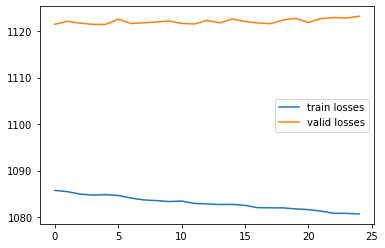

In [396]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()

In [242]:
import pandas as pd


plot_df = pd.DataFrame({'true': batch_label.detach().numpy(), 'pred': pred_label.squeeze().detach().numpy(),\
                        'dataPair1':batch_pair[:,0].detach().numpy(), 'dataPair2':batch_pair[:,1].detach().numpy()})
plot_df.head()

,true,pred,dataPair1,dataPair2
0,1.0,0.744528,25.781141,43.624172
1,1.0,0.744528,15.027925,21.310776
2,1.0,0.744528,20.414146,30.561441
3,1.0,0.744528,22.647816,30.683744
4,0.0,0.742164,15.022316,19.621126


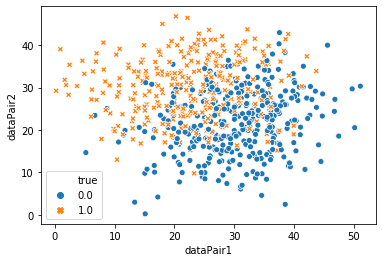

In [243]:
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")


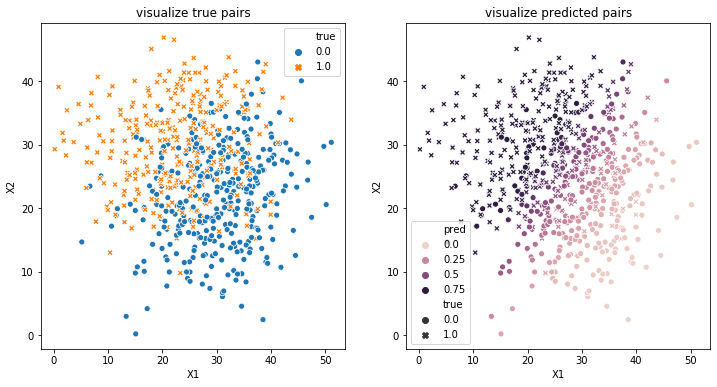

In [244]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)

_ = plt.title('visualize true pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')
plt.subplot(1, 2, 2)



_ = plt.title('visualize predicted pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="pred", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

In [257]:
subj = np.random.sample(np.where(test['e']==1))
subj

TypeError: only integer scalar arrays can be converted to a scalar index

In [258]:
np.where(test['e']==1)

(array([  14,   16,   19, ..., 4992, 4996, 4998]),)

In [288]:
np.where(test['e']==1)
subj = 14

In [422]:
# Restore variables from disk.
clf.load_state_dict(torch.load(clf_path))
print("Model restored.")

# new object to predict g(x_subj)
# on the left
# subj = 2
# on the right
# subj=6
# relatively good 
# subj=8
x_subj = test['x'][subj]     # You can play with this
# x_subj = train['x'][subj]
draw_dataset = test
# Return evenly spaced numbers over a specified interval.
# is tt the we want?
# change tt to percentage scale

tt = np.percentile(train['T'],np.delete(np.linspace(0.,100.,1000, endpoint=False),0))
tt_bin = np.ones(len(tt))
# tt = np.linspace(ST[0]-0.5,ST[-1]+0.5,1000).reshape(1000)
# tt_bin = [y-x for x, y in zip(tt[:-1], tt[1:])]
# tt = np.delete(tt,0)

# SFX sorted original training dataset
x_subj_query = np.concatenate((np.tile(x_subj,[SX.shape[0],1]),SX),axis=1)

prob_subj = clf(torch.tensor(x_subj_query).to(device).float()).squeeze().detach().numpy()

# ST: sorted g(X_train)
# returns a matrix of size(tt)*size(ST)
# each ST corresponding to SFX
TC = compute_concord(tt,ST)

EPS = 1e-10
#aggregate information over bins
# binomial log-likelihood
tau = 0.2
score = np.mean(np.log(prob_subj+EPS)*TC+np.log(1-prob_subj+EPS)*(1-TC),axis=1)
score = score/tau
# normalize based on bin size!
post_prob = (np.exp(score)*tt_bin)/np.sum(np.exp(score)*tt_bin)

# np.save(output_dir+'/'+'M'+str(M0)+'replicate'+str(replicate_number)+"_MLP_post_prob",post_prob)




RuntimeError: Error(s) in loading state_dict for SimpleMLP:
	size mismatch for net.0.weight: copying a param with shape torch.Size([32, 2]) from checkpoint, the shape in current model is torch.Size([32, 4]).

In [2]:
width = 18
height = 6
plt.figure(figsize=(width, height))
plt.subplot(1,2,1)

plt.plot(SX, prob_subj, 'o')
plt.xlabel("sorted training X")
plt.ylabel("classifier output")
plt.axvline(draw_dataset['x'][subj],linestyle='--', label='x_k')
plt.legend()

plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")


# plt.subplot(1,3,2)
# plt.plot(ST, prob_subj, 'o')
# plt.xlabel("training T based on sorted X")
# plt.ylabel("classifier output")
# plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
# plt.legend()
# plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")
# # plt.xlim(50,80)

plt.subplot(1,2,2)
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']

plt.plot(tt, post_prob/0.1, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False,label="Empirical")
plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')


#
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')


plt.legend()
plt.title("Time-to-event distribution, event label:{}".format(test['e'][subj]))

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'Time-to-event distribution')

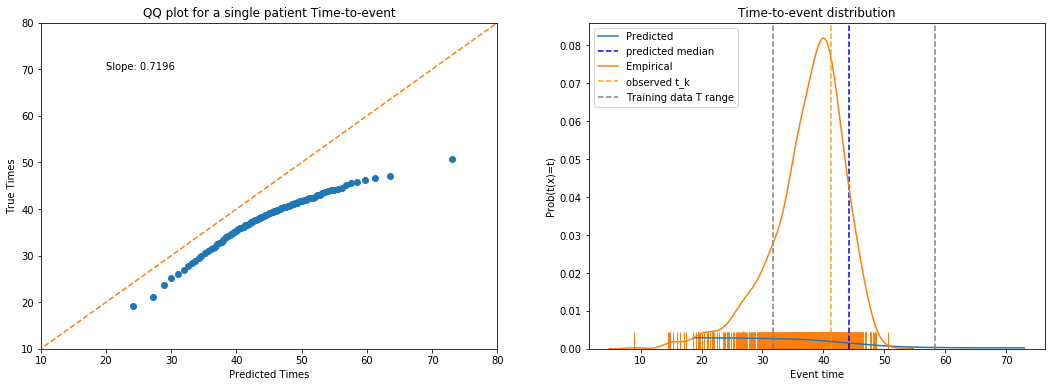

In [282]:
# calculate QQ-plot
import numpy as np
import matplotlib.pyplot as plt


pred_quantiles = calculate_quantiles(post_prob, tt, percentiles=np.linspace(0,1,100))
true_quantiles = np.percentile(true_T,np.linspace(0,100,100))
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(pred_quantiles, true_quantiles)

width = 18
height = 6
plt.figure(figsize=(width, height))

plt.subplot(1,2,1)
plt.text(20,70, 'Slope: '+str(np.round(slope,4)))
plt.plot(pred_quantiles, true_quantiles, 'o')
plt.plot(np.linspace(0,100,100),np.linspace(0,100,100), linestyle='--')
plt.xlim(10,80)
plt.ylim(10,80)
plt.xlabel('Predicted Times')
plt.ylabel('True Times')
plt.title('QQ plot for a single patient Time-to-event')

plt.subplot(1,2,2)
plt.plot(tt, post_prob, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False, label="Empirical")

plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')

plt.legend()
plt.title("Time-to-event distribution")

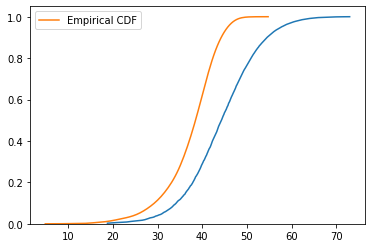

In [283]:
plt.plot(tt,np.cumsum(post_prob))
sns.distplot(true_T, hist=False, label="Empirical CDF", kde_kws=dict(cumulative=True))
